In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

- [Graph: Infographic Visualization](#infographic_visualization)

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ USA Vaccines ](#build_USA_Vaccines)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##
- [ Blog Graphs ](#build_blog_graphs)

## HTML Processing ##


### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
#use_cached_files = True
#rebuild_master_files = False

out_controls = {}
manage_df = {}

# Filepaths #

In [5]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [6]:
county_daily_df = pd.read_pickle(county_daily_df_filename)


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [7]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

manage_df["county_vax_df"] = "County Vaccination Data [ 2020-12-13 - Present ]"

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

Date   FIPS       Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
0        2021-11-14  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0
1        2021-11-14  21219        Todd County          KY                      38.3                    4705            43.0            5282.0
2        2021-11-14  26047       Emmet County          MI                      68.5                   22875            72.2           24135.0
3        2021-11-14  40079    Le Flore County          OK                      35.5                   17684            40.6           20247.0
4        2021-11-14  16057       Latah County          ID                      50.1                   20098            56.0           22467.0
...             ...    ...                ...         ...                       ...                     ...             ...               ...
1109340  2020-12-13  55023    Crawford County          WI                       0.0                       0             0.0               0.0
1109341  2020-12-13  47153  Sequatchie County          TN                       0.0                       0             0.0               0.0
1109342  2020-12-13  34015  Gloucester County          NJ                       0.0                       0             0.0               0.0
1109343  2020-12-13  45061         Lee County          SC                       0.0                       0             0.0               0.0
1109344  2020-12-13  26061    Houghton County          MI                       0.0                       0             0.0               0.0

[1050711 rows x 8 columns]

<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [8]:
state_daily_df = pd.read_pickle(state_daily_df_filename)
state_daily_df

manage_df['state_daily_df'] = "State Population Vaccination Case Death [2020-12-14 - Present]"

# Read all dates JSON
with open(all_dates_filename, "r") as infile:
    all_dates = json.loads(infile.read())['all_dates']

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [9]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************

manage_df['confirm_df'] = "Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]"
manage_df['death_df'] = "Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]"
#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df

manage_df['state_case_death'] = "State Level Cases and Deaths Only [2020/01/30 - Present]"
#print(state_case_death_df)

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [10]:
attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
manage_df['attrib_confirm_df'] = "Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]"
attrib_death_df = pd.read_pickle(attrib_death_filename)
manage_df['attrib_death_df'] = "Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]"
#print("Loading Cached: death_df")

- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [11]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down
manage_df['hospital_df'] = "Statewide Hospitalization Numbers [2020-01-01 - Present]"
hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

state        Date  short_staffed  got_covid_at_hosp  total_beds  beds_used  covid_beds_used  icu_occupancy  covid_icu  covid_beds_adult  covid_beds_kids  icu_total  beds_used_pct  \
25388    NC  2020-01-01            0.0                0.0        72.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
25607    TX  2020-01-01            0.0                0.0       790.0       42.0              0.0            NaN        NaN               NaN              NaN        NaN       0.656250   
31945    MT  2020-01-01            0.0                0.0        36.0       12.0              0.0            NaN        NaN               NaN              NaN        NaN       0.333333   
28150    PR  2020-01-01            0.0                0.0       146.0       61.0              0.0            NaN        NaN               NaN              NaN        NaN       0.417808   
29086    HI  2020-01-01            0.0                0.0         0.0        0.0              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
...     ...         ...            ...                ...         ...        ...              ...            ...        ...               ...              ...        ...            ...   
18204    DC  2021-11-15            0.0                0.0      3414.0     2548.0             62.0          240.0       12.0              57.0              5.0      332.0       0.746339   
22338    NM  2021-11-15           25.0                1.0      4056.0     2918.0            581.0          371.0      166.0             572.0              9.0      419.0       0.751868   
19543    UT  2021-11-15            1.0                0.0      5509.0     3488.0            541.0          455.0      203.0             522.0             19.0      621.0       0.633146   
13378    MA  2021-11-15           18.0               10.0     16535.0    13735.0            495.0         1032.0      128.0             486.0              9.0     1297.0       0.830662   
17285    WI  2021-11-15           40.0                8.0     11751.0     8269.0           1174.0          974.0      296.0            1147.0             27.0     1461.0       0.703685   

       covid_patients_pct  covid_beds_pct  icu_used  icu_used_pct  therapy_a  therapy_b  therapy_b  
25388                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
25607            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
31945            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
28150            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
29086                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
...                   ...             ...       ...           ...        ...        ...        ...  
18204            0.025275        0.018885  0.038585      0.722892      442.0      320.0      292.0  
22338            0.171859        0.147126  0.417085      0.936869      223.0        0.0       69.0  
19543            0.157405        0.099577  0.332242      0.732689      460.0      248.0       77.0  
13378            0.036349        0.030183  0.100708      0.795682     1732.0        0.0     2500.0  
17285            0.145064        0.102167  0.212644      0.666667     4358.0     2139.0     2666.0  

[33437 rows x 20 columns]

<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [12]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats
manage_df['vax_tier_state_df'] = "State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]"
vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


41.2
72.0


level_0  index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  \
0          0      0 2020-12-28  total_40     4157971                       0                 0       262150       3045       3040          65     5152.357143        76.357143     123.915177   
1          1      0 2020-12-29  total_40     4157971                       0                 0       265220       3082       5095         101     5085.214286        77.142857     122.300379   
2          2      0 2020-12-30  total_40     4157971                       0                 0       268222       3126       6072          81     5074.285714        75.428571     122.037545   
3          3      0 2020-12-31  total_40     4157971                       0                 0       270820       3212       5600         130     5033.928571        75.642857     121.066948   
4          4      0 2021-01-01  total_40     4157971                       0                 0       273306       3235       5084         109     4917.285714        74.928571     118.261665   
..       ...    ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...   
317      317      0 2021-11-10  total_40     4157971                 1789037           2069918       685026       9593       3316         124     3634.214286        82.571429      87.403551   
318      318      0 2021-11-11  total_40     4157971                 1790736           2072497       686059       9611       3025          64     3488.428571        77.928571      83.897376   
319      319      0 2021-11-12  total_40     4157971                 1790979           2073356       688924       9643       3898          50     3422.857143        73.428571      82.320371   
320      320      0 2021-11-13  total_40     4157971                 1792606           2076044       689737       9653       3678          42     3416.428571        73.142857      82.165762   
321      321      0 2021-11-14  total_40     4157971                 1794134           2077912       690407       9653       1483          10     3380.071429        73.571429      81.291366   

     death_avg_100k  total_vaccinated_percent  first_dose_pct  
0          1.836404                  0.000000        0.000000  
1          1.855301                  0.000000        0.000000  
2          1.814072                  0.000000        0.000000  
3          1.819225                  0.000000        0.000000  
4          1.802047                  0.000000        0.000000  
..              ...                       ...             ...  
317        1.985859                  0.430267        0.497819  
318        1.874197                  0.430675        0.498440  
319        1.765971                  0.430734        0.498646  
320        1.759100                  0.431125        0.499293  
321        1.769407                  0.431493        0.499742  

[322 rows x 17 columns]

- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [13]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
manage_df['state_hospital_tiers_df'] = "Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]"
state_hosp_tiers_df

{40: {'FIPS': [16, 54, 56], 'state': ['ID', 'WV', 'WY']}, 45: {'FIPS': [1, 5, 13, 22, 28, 38, 47], 'state': ['AL', 'AR', 'GA', 'LA', 'MS', 'ND', 'TN']}, 50: {'FIPS': [4, 18, 20, 21, 26, 29, 30, 32, 37, 39, 40, 45, 46, 48, 49], 'state': ['AZ', 'IN', 'KS', 'KY', 'MI', 'MO', 'MT', 'NV', 'NC', 'OH', 'OK', 'SC', 'SD', 'TX', 'UT']}, 55: {'FIPS': [19, 31, 55], 'state': ['IA', 'NE', 'WI']}, 60: {'FIPS': [6, 8, 10, 12, 17, 27, 33, 35, 41, 42, 51, 53], 'state': ['CA', 'CO', 'DE', 'FL', 'IL', 'MN', 'NH', 'NM', 'OR', 'PA', 'VA', 'WA']}, 65: {'FIPS': [24, 34, 36], 'state': ['MD', 'NJ', 'NY']}, 70: {'FIPS': [9, 23, 25, 44, 50], 'state': ['CT', 'ME', 'MA', 'RI', 'VT']}}
40
45
50
55
60
65
70
Done!


population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
5983    4157971 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5984    4157971 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5985    4157971 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5986    4157971 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5987    4157971 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3973   13485352 2021-11-10     32404     1607201      7152         81     6119.285714     45.377278        48.714286       0.361239  CT  [9, 23, 25, 44, 50]  total_70    33189.0   28050.0   
3974   13485352 2021-11-11     32410     1609107      5769         36     5978.714286     44.334877        43.571429       0.323102  CT  [9, 23, 25, 44, 50]  total_70    33342.0   28162.0   
3975   13485352 2021-11-12     32433     1614818      7617         29     6057.428571      44.91858        37.000000       0.274372  CT  [9, 23, 25, 44, 50]  total_70    33333.0   28075.0   
3976   13485352 2021-11-13     32443     1616076      6969         33     6438.000000     47.740689        35.142857         0.2606  CT  [9, 23, 25, 44, 50]  total_70    33227.0   27656.0   
3977   13485352 2021-11-14     32443     1616387      1569         10     6466.857143     47.954678        36.000000       0.266956  CT  [9, 23, 25, 44, 50]  total_70    33183.0   27367.0   

     covid_beds_used icu_total            icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
5983             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5984             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5985             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5986             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5987             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                 ...       ...              ...             ...              ...               ...  
3973          1155.0    2931.0   0.676863184429305     293.0           1140.0            15.0        45.377278          0.361239  
3974          1170.0    2924.0   0.618018181102465     283.0           1159.0            11.0        44.334877          0.323102  
3975          1182.0    2925.0  0.6315809232581641     291.0           1166.0            16.0         44.91858          0.274372  
3976          1178.0    2912.0   0.629324769381803     286.0           1169.0             9.0        47.740689            0.2606  
3977          1206.0    2908.0   0.611212613505661     285.0           1195.0            11.0        47.954678          0.266956  

[4529 rows x 23 columns]

<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [14]:
print("Loading Cached County Tier Data")
county_tier_df = pd.read_pickle(county_tier_df_filename)
manage_df['county_tier_df'] = "Tiers County Vaccinations Cases Deaths[2020-12-21 - Present]"
county_tier_df

Loading Cached County Tier Data


Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849      968563      16521       15589        104    21784.285714   
335  2020-12-22  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849      981752      16720       19945        244    21887.428571   
336  2020-12-23  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849      993854      16901       25291        380    22036.285714   
337  2020-12-24  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849     1007761      17069       26009        349    22209.000000   
338  2020-12-25  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849     1015400      17161       21546        260    21502.714286   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
658  2021-11-10  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1447838      23468        1815         16     2326.000000   
659  2021-11-11  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1448495      23469        1643          8     2300.714286   
660  2021-11-12  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       263.857143    125.349416       1.518266              100          1.518266                      0.0                      0            0.0              0.0  total_30  
335       263.571429    125.942912       1.516622              100          1.516622                      0.0                      0            0.0              0.0  total_30  
336       267.714286    126.799454        1.54046              100           1.54046                      0.0                      0            0.0              0.0  total_30  
337       266.714286    127.793273       1.534706              100          1.534706                      0.0                      0            0.0              0.0  total_30  
338       261.000000     123.72922       1.501826              100          1.501826                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
658        16.857143     22.229488       0.161103        22.229488          0.161103                76.576131                8012604      86.814827        9083938.0  total_75  
659        14.428571     21.987833       0.137893        21.987833          0.137893                 76.64865                8020192      86.960752        9099207.0  total_75  
660        10.714286     21.676549       0.102396        21.676549          0

In [15]:
print("Loading Cached Whole County Tier Data")
whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
manage_df['whole_county_tier_df'] = ["tier county cases and deaths [2020-02-06 - Present]"]
whole_county_tier_df

Loading Cached Whole County Tier Data


Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
16   2020-02-07  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
17   2020-02-08  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
18   2020-02-09  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
19   2020-02-10  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
658  2021-11-10  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1447838      23468        1815         16     2326.000000   
659  2021-11-11  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1448495      23469        1643          8     2300.714286   
660  2021-11-12  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
658        16.857143     22.229488       0.161103        22.229488          0.161103  total_75  
659        14.428571     21.987833       0.137893        21.987833          0.137893  total_75  
660        10.714286     21.676549       0.102396        21.676549          0.102396  total_75  
661        12.142857     22.751025       0.116049        22.751025          0.116049  total_75  
662        13.714286     22.305943       0.131067        22.305943          0.131067  total_75  

[6480 rows x 17 columns]

In [16]:
whole_county_tier_df[whole_county_tier_df['tier'] == 'total_50']

Date                                               FIPS     Admin2 Province_State            Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
16   2020-02-07  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
17   2020-02-08  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
18   2020-02-09  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
19   2020-02-10  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319           1          0           0          0        0.000000   
..          ...                                                ...        ...            ...                     ...        ...         ...        ...         ...        ...             ...   
658  2021-11-10  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8513157     125146       32949        499    28977.428571   
659  2021-11-11  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8526557     125334       32264        520    28749.000000   
660  2021-11-12  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8551142     125584       37985        438    29498.000000   
661  2021-11-13  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8562152     125692       35595        358    31383.571429   
662  2021-11-14  [16057, 32021, 47047, 21185, 29095, 36025, 270...  Jefferson        Alabama  Jefferson, Alabama, US   57184319     8566827     125707       15685        123    31592.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_50  
16          0.000000           0.0            0.0              0.0               0.0  total_50  
17          0.000000           0.0            0.0              0.0               0.0  total_50  
18          0.000000           0.0            0.0              0.0               0.0  total_50  
19          0.000000           0.0            0.0              0.0               0.0  total_50  
..               ...           ...            ...              ...               ...       ...  
658       386.142857     50.673732        0.67526        50.673732           0.67526  total_50  
659       380.142857     50.274272       0.664768        50.274272          0.664768  total_50  
660       375.142857     51.584072       0.656024        51.584072          0.656024  total_50  
661       375.857143     54.881429       0.657273        54.881429          0.657273  total_50  
662       378.714286     55.245915       0.662269        55.245915          0.662269  total_50  

[648 rows x 17 columns]

- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

In [17]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        loop_dict['Population'] = loop_df['Population'].iloc[0]



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())

manage_df['start_summary_df'] = "Summary Stats Beginning: Case Death by Tier From the Start of Pandemic to Summer Surge"
manage_df['summer_summary_df'] = "Summary Stats Summer: Case Death by Tier From the Start of Summer Surge to Present"
start_summary_df 
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
0    10274.201703
1    10792.177729
2    10624.439651
3    10666.036959
4    10634.509786
5     9725.614571
6    10127.469430
7     9717.642119
8     8409.292176
9    10882.079640
Name: confirm_period_100k, dtype: float64
10    5125.040214
11    5704.956269
12    5555.327998
13    5030.623553
14    4341.046712
15    4076.851842
16    3068.711269
17    2680.211326
18    2222.358119
19    2995.800959
Name: confirm_period_100k, dtype: float64

0    1.000000
1    1.050415
2    1.034089
3    1.038138
4    1.035069
5    0.946605
6    0.985718
7    0.945829
8    0.818486
9    1.059165
Name: confirm_period_100k, dtype: float64
10    1.000000
11    1.113153
12    1.083958
13    0.981577
14    0.847027
15    0.795477
16    0.598768
17    0.522964
18    0.433627
19    0.584542
Name: confirm_period_100k, dtype: float64
[ 0.         -0.06273826 -0.04986887  0.0565604   0.18804235  0.15112833
  0.38695014  0.42286545  0.38485874  0.47462352]
0    197.832434
1    209.125645
2   

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    17378849  0.053310  2020-02-06  2021-06-30         1785538         10274.201703           34381         197.832434
1      0  total_35  start    16593852  0.050902  2020-02-06  2021-06-30         1790838         10792.177729           34702         209.125645
2      0  total_40  start    21435314  0.065753  2020-02-06  2021-06-30         2277382         10624.439651           42951         200.374951
3      0  total_45  start    33132831  0.101635  2020-02-06  2021-06-30         3533960         10666.036959           62340         188.151746
4      0  total_50  start    57184319  0.175413  2020-02-06  2021-06-30         6081272         10634.509786          100184         175.194882
5      0  total_55  start    55849540  0.171319  2020-02-06  2021-06-30         5431711          9725.614571           83872         150.174916
6      0  total_60  start    70585787  0.216522  2020-02-06  2021-06-30         7148554         10127.469430          137508         194.809757
7      0  total_65  start    23833158  0.073108  2020-02-06  2021-06-30         2316021          9717.642119           42705         179.183136
8      0  total_70  start    19540955  0.059942  2020-02-06  2021-06-30         1643256          8409.292176           32559         166.619288
9      0  total_75  start    10463579  0.032097  2020-02-06  2021-06-30         1138655         10882.079640           22826         218.147156

In [18]:
start_summary_df

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0      0  total_30  start    17378849  0.053310  2020-02-06  2021-06-30         1785538         10274.201703           34381         197.832434
1      0  total_35  start    16593852  0.050902  2020-02-06  2021-06-30         1790838         10792.177729           34702         209.125645
2      0  total_40  start    21435314  0.065753  2020-02-06  2021-06-30         2277382         10624.439651           42951         200.374951
3      0  total_45  start    33132831  0.101635  2020-02-06  2021-06-30         3533960         10666.036959           62340         188.151746
4      0  total_50  start    57184319  0.175413  2020-02-06  2021-06-30         6081272         10634.509786          100184         175.194882
5      0  total_55  start    55849540  0.171319  2020-02-06  2021-06-30         5431711          9725.614571           83872         150.174916
6      0  total_60  start    70585787  0.216522  2020-02-06  2021-06-30         7148554         10127.469430          137508         194.809757
7      0  total_65  start    23833158  0.073108  2020-02-06  2021-06-30         2316021          9717.642119           42705         179.183136
8      0  total_70  start    19540955  0.059942  2020-02-06  2021-06-30         1643256          8409.292176           32559         166.619288
9      0  total_75  start    10463579  0.032097  2020-02-06  2021-06-30         1138655         10882.079640           22826         218.147156

In [19]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
1116     2021-11-14  35031  McKinley County          NM                      73.0                   52117            93.7           66843.0
5531     2021-11-13  35031  McKinley County          NM                      73.0                   52089            93.3           66597.0
7765     2021-11-13  35031  McKinley County          NM                      73.0                   52089            93.3           66597.0
11523    2021-11-12  35031  McKinley County          NM                      72.9                   51999            92.9           66301.0
16215    2021-11-11  35031  McKinley County          NM                      72.8                   51972            92.7           66180.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1095141  2020-12-17  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1097168  2020-12-16  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1099701  2020-12-15  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1104896  2020-12-14  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1109145  2020-12-13  35031  McKinley County          NM                       0.0                       0             0.0               0.0

[338 rows x 8 columns]

# Build Statewide Overview Summary Dictionary #

In [20]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "

manage_df['overview_state_dict'] = "Tier Summary StateWide Data: Summary based on last day of State data: "
overview_state_dict


{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 428257,
  'confirm_start': 262150,
  'confirm_end': 690407,
  'confirm_period_100k': 10299.662984662471,
  'confirm_deaths': 6608,
  'death_period_100k': 158.92366733678517,
  'vax_complete': 1794134,
  'vax_complete_100k': 43149.26679382805,
  'vax_partial': 2077912,
  'vax_partial_100k': 49974.182119115314,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2020-12-28 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 3360856,
  'confirm_start': 2368642,
  'confirm_end': 5729498,
  'confirm_period_100k': 9956.737440545496,
  'confirm_deaths': 58931,
  'death_period_100k': 174.58662141692074,
  'vax_complete': 16208680,
  'vax_complete_100k': 48019.18648636567,
  'vax_part

# Statewide Vax Tier Graphs #

In [21]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0127 confirm 100k:10299 Death 100k:158 Vaccine 100k:43149
total_45 pop pct:0.1032 confirm 100k:9956 Death 100k:174 Vaccine 100k:48019
total_50 pop pct:0.3241 confirm 100k:8777 Death 100k:138 Vaccine 100k:52936
total_55 pop pct:0.0334 confirm 100k:7068 Death 100k:79 Vaccine 100k:57751
total_60 pop pct:0.3804 confirm 100k:7879 Death 100k:101 Vaccine 100k:61763
total_65 pop pct:0.1463 confirm 100k:7642 Death 100k:97 Vaccine 100k:68336


# Build Statewide Overview Summer Summary Dictionary #

In [22]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 401064,
  'confirm_start': 289343,
  'confirm_end': 690407,
  'confirm_period_100k': 9645.666119364469,
  'confirm_deaths': 6129,
  'death_period_100k': 147.40362547021132,
  'vax_complete': 1794134,
  'vax_complete_100k': 43149.26679382805,
  'vax_partial': 2077912,
  'vax_partial_100k': 49974.182119115314,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 3076040,
  'confirm_start': 2653458,
  'confirm_end': 5729498,
  'confirm_period_100k': 9112.95296097648,
  'confirm_deaths': 55923,
  'death_period_100k': 165.67524103610083,
  'vax_complete': 16208680,
  'vax_complete_100k': 48019.18648636567,
  'vax_partia

# Summer Statewide Vax Tier Graphs #

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [23]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

manage_df['state_hosp_tier_summary_df'] = "Summary Comparison of Statewide Tiers Before and After Surge"        
state_hosp_tier_summary_df

tier  period  population   pop_pct date_start   date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0  total_40   start     4157971  0.012779 2020-02-07 2021-06-30          421329         10133.043256            5790         139.250610
0  total_45   start    33754591  0.103737 2020-02-07 2021-06-30         3815843         11304.663712           70819         209.805534
0  total_50   start   106034509  0.325873 2020-02-07 2021-06-30        11051416         10422.471047          188222         177.510135
0  total_55   start    10911912  0.033535 2020-02-07 2021-06-30         1275971         11693.376926           16496         151.174240
0  total_60   start   122660591  0.376969 2020-02-07 2021-06-30        11780228          9603.922420          192948         157.302356
0  total_65   start    34381431  0.105663 2020-02-07 2021-06-30         3600660         10472.688004           89632         260.698864
0  total_70   start    13485352  0.041444 2020-02-07 2021-06-30         1302440          9658.183190           30091         223.138410
0  total_40  summer     4157971  0.012779 2021-07-01 2021-11-14          268868          6466.326966            3855          92.713489
0  total_45  summer    33754591  0.103737 2021-07-01 2021-11-14         1911483          5662.883013           26778          79.331431
0  total_50  summer   106034509  0.325873 2021-07-01 2021-11-14         4708306          4440.352527           59246          55.874263
0  total_55  summer    10911912  0.033535 2021-07-01 2021-11-14          444703          4075.390271            2571          23.561407
0  total_60  summer   122660591  0.376969 2021-07-01 2021-11-14         4592019          3743.679174           30066          24.511540
0  total_65  summer    34381431  0.105663 2021-07-01 2021-11-14          815209          2371.073502            6460          18.789212
0  total_70  summer    13485352  0.041444 2021-07-01 2021-11-14          313800          2326.969292            2346          17.396654

In [24]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()

manage_df['county_summary_df'] = "County Summary Stats Confirm and Deaths for Pre/Post Surge"

2020-02-06
0    10274.201703
1    10792.177729
2    10624.439651
3    10666.036959
4    10634.509786
5     9725.614571
6    10127.469430
7     9717.642119
8     8409.292176
9    10882.079640
Name: confirm_period_100k, dtype: float64
10    5125.040214
11    5704.956269
12    5555.327998
13    5030.623553
14    4341.046712
15    4076.851842
16    3068.711269
17    2680.211326
18    2222.358119
19    2995.800959
Name: confirm_period_100k, dtype: float64
0    0.498826
1    0.528620
2    0.522882
3    0.471649
4    0.408204
5    0.419187
6    0.303009
7    0.275809
8    0.264274
9    0.275297
dtype: float64
0    0.409965
1    0.397989
2    0.390119
3    0.303481
4    0.253853
5    0.219048
6    0.117324
7    0.091043
8    0.084585
9    0.029002
dtype: float64



In [25]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [26]:
county_summary_df

index      tier  period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0       0  total_30   start    17378849  0.053410  2020-02-06  2021-06-30         1785538         10274.201703           34381         197.832434
1       0  total_35   start    16593852  0.050997  2020-02-06  2021-06-30         1790838         10792.177729           34702         209.125645
2       0  total_40   start    21435314  0.065876  2020-02-06  2021-06-30         2277382         10624.439651           42951         200.374951
3       0  total_45   start    33132831  0.101826  2020-02-06  2021-06-30         3533960         10666.036959           62340         188.151746
4       0  total_50   start    57184319  0.175743  2020-02-06  2021-06-30         6081272         10634.509786          100184         175.194882
5       0  total_55   start    55849540  0.171641  2020-02-06  2021-06-30         5431711          9725.614571           83872         150.174916
6       0  total_60   start    70585787  0.216929  2020-02-06  2021-06-30         7148554         10127.469430          137508         194.809757
7       0  total_65   start    23833158  0.073246  2020-02-06  2021-06-30         2316021          9717.642119           42705         179.183136
8       0  total_70   start    19540955  0.060055  2020-02-06  2021-06-30         1643256          8409.292176           32559         166.619288
9       0  total_75   start    10463579  0.032157  2020-02-06  2021-06-30         1138655         10882.079640           22826         218.147156
10      0  total_30  summer    17378849  0.053410  2021-07-01  2021-11-14          890673          5125.040214           14095          81.104336
11      0  total_35  summer    16593852  0.050997  2021-07-01  2021-11-14          946672          5704.956269           13811          83.229620
12      0  total_40  summer    21435314  0.065876  2021-07-01  2021-11-14         1190802          5555.327998           16756          78.170070
13      0  total_45  summer    33132831  0.101826  2021-07-01  2021-11-14         1666788          5030.623553           18919          57.100463
14      0  total_50  summer    57184319  0.175743  2021-07-01  2021-11-14         2482398          4341.046712           25432          44.473731
15      0  total_55  summer    55849540  0.171641  2021-07-01  2021-11-14         2276903          4076.851842           18372          32.895526
16      0  total_60  summer    70585787  0.216929  2021-07-01  2021-11-14         2166074          3068.711269           16133          22.855876
17      0  total_65  summer    23833158  0.073246  2021-07-01  2021-11-14          638779          2680.211326            3888          16.313407
18      0  total_70  summer    19540955  0.060055  2021-07-01  2021-11-14          434270          2222.358119            2754          14.093477
19      0  total_75  summer    10463579  0.032157  2021-07-01  2021-11-14          313468          2995.800959             662           6.326707

In [27]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']


#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
#geo_county_tier_df.plot()


print(state_daily_df)

3220
     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
335        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
334        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
333        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
332        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
331        1      1  Alabama  POLYGON ((-88.46866 31.89

In [28]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

whole_county_tier_df
county_vax_df
#county_vax_tier_df 

tdf
geo_county_vax_tier_df = county_vax_df.merge(tdf,left_on="FIPS",right_on="FIPS")

geo_county_vax_tier_df

Date   FIPS       Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count      tier
0        2021-11-14  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
1        2021-11-13  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
2        2021-11-13  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
3        2021-11-12  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
4        2021-11-11  13265  Taliaferro County          GA                      22.1                     340            23.7             364.0  total_30
...             ...    ...                ...         ...                       ...                     ...             ...               ...       ...
1047664  2020-12-17  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40
1047665  2020-12-16  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40
1047666  2020-12-15  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40
1047667  2020-12-14  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40
1047668  2020-12-13  13039      Camden County          GA                       0.0                       0             0.0               0.0  total_40

[1047669 rows x 9 columns]

- [ USA Vaccines ](#build_USA_Vaccines)
<a id="build_USA_Vaccines"></a> 
# USA Vaccines #

In [29]:
usa_vax_df = pd.DataFrame()
cols = ['Date','population','total_vaccinated_count','total_vaccinated_pct']
for group in state_daily_df.groupby("Date"):
    
    print(group[0],group[1].population.sum(),group[1]['total_vaccinated_count'].sum(),(group[1]['total_vaccinated_count'].sum()/group[1].population.sum()))
    tdf = pd.DataFrame({'Date' : [group[0]],'population' : [group[1].population.sum()],'total_vaccinated_count' : [group[1]['total_vaccinated_count'].sum()],        'total_vaccinated_pct' : [(group[1]['total_vaccinated_count'].sum()/group[1].population.sum())] })
    usa_vax_df = pd.concat([usa_vax_df,tdf])
usa_vax_df

2020-12-14 00:00:00 325386357 0 0.0
2020-12-15 00:00:00 325386357 0 0.0
2020-12-16 00:00:00 325386357 0 0.0
2020-12-17 00:00:00 325386357 0 0.0
2020-12-18 00:00:00 325386357 0 0.0
2020-12-19 00:00:00 325386357 0 0.0
2020-12-20 00:00:00 325386357 0 0.0
2020-12-21 00:00:00 325386357 0 0.0
2020-12-22 00:00:00 325386357 0 0.0
2020-12-23 00:00:00 325386357 0 0.0
2020-12-24 00:00:00 325386357 0 0.0
2020-12-25 00:00:00 325386357 0 0.0
2020-12-26 00:00:00 325386357 0 0.0
2020-12-27 00:00:00 325386357 0 0.0
2020-12-28 00:00:00 325386357 0 0.0
2020-12-29 00:00:00 325386357 0 0.0
2020-12-30 00:00:00 325386357 0 0.0
2020-12-31 00:00:00 325386357 0 0.0
2021-01-01 00:00:00 325386357 0 0.0
2021-01-02 00:00:00 325386357 0 0.0
2021-01-03 00:00:00 325386357 0 0.0
2021-01-04 00:00:00 325386357 0 0.0
2021-01-05 00:00:00 325386357 0 0.0
2021-01-06 00:00:00 325386357 0 0.0
2021-01-07 00:00:00 325386357 0 0.0
2021-01-08 00:00:00 325386357 0 0.0
2021-01-09 00:00:00 325386357 0 0.0
2021-01-10 00:00:00 32538635

2021-06-13 00:00:00 325386357 140092638 0.4305424458838021
2021-06-14 00:00:00 325386357 141059369 0.4335134708797886
2021-06-15 00:00:00 325386357 141877329 0.4360272824837582
2021-06-16 00:00:00 325386357 142544525 0.43807775566939333
2021-06-17 00:00:00 325386357 143809329 0.4419648393555726
2021-06-18 00:00:00 325386357 144482073 0.4440323630409618
2021-06-19 00:00:00 325386357 145119786 0.4459922270189097
2021-06-20 00:00:00 325386357 145644154 0.4476037512537749
2021-06-21 00:00:00 325386357 146009764 0.44872736935310414
2021-06-22 00:00:00 325386357 146384214 0.4498781551557185
2021-06-23 00:00:00 325386357 146728943 0.4509376003124802
2021-06-24 00:00:00 325386357 147172233 0.452299949994523
2021-06-25 00:00:00 325386357 147499409 0.453305450049954
2021-06-26 00:00:00 325386357 148035905 0.45495424689855696
2021-06-27 00:00:00 325386357 148873392 0.4575280702380524
2021-06-28 00:00:00 325386357 149594858 0.45974532976500915
2021-06-29 00:00:00 325386357 150001427 0.460994825913

Date  population  total_vaccinated_count  total_vaccinated_pct
0  2020-12-14   325386357                       0              0.000000
0  2020-12-15   325386357                       0              0.000000
0  2020-12-16   325386357                       0              0.000000
0  2020-12-17   325386357                       0              0.000000
0  2020-12-18   325386357                       0              0.000000
..        ...         ...                     ...                   ...
0  2021-11-10   325386357               188571167              0.579530
0  2021-11-11   325386357               188754145              0.580092
0  2021-11-12   325386357               188918647              0.580598
0  2021-11-13   325386357               189111522              0.581191
0  2021-11-14   325386357               189274501              0.581692

[336 rows x 4 columns]

In [30]:
plot_df = usa_vax_df[usa_vax_df['total_vaccinated_count'] > 0 ].copy().reset_index()
plot_df['total_vaccinated_pct'] = (plot_df['total_vaccinated_pct']*100)
exec_fig_width =1280
exec_fig_height=720
fontsize=15
#figsize=(600*px, 200*px)
base_path = "./final_video/usa_vax/"
base_filename = "_usa_vax.jpg"



filelist = []
filecounter = 0
for i in range(1,len(plot_df),2):
    filecounter+=1
    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    
    fig, ax = plt.subplots()
    fig = plt.gcf()
    #fig.set_size_inches(5,3)
    DPI = fig.get_dpi()
    #fig = plt.gcf()
    
    fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))
    #print(plot_df['Date'][:i],plot_df['total_vaccinated_pct'][:i])
    ax.fill_between(plot_df['Date'][:i], plot_df['total_vaccinated_pct'][:i],
             #labels=labels,
             color='red',
             linewidth=2,
             alpha=.3,
            )

    ax.plot(plot_df['Date'][:i], plot_df['total_vaccinated_pct'][:i],
                 #labels=labels,
                 color='red',
                 linewidth=2,
                )
    #//*** Add % to ytick labels
    
    ax.set_ylim(0, usa_vax_df['total_vaccinated_pct'].max()* 100)
    ax.set_xlim(usa_vax_df['Date'].min(), usa_vax_df['Date'].max())
    
    tick_labels = []
    for label in ax.get_yticks()[1:]:
        tick_labels.append(str(int(label))+'%')
    
    ax.set_yticks(ax.get_yticks()[1:])
    ax.set_yticklabels(tick_labels)
    
    plt.title(f'U.S. Total Vaccination Rate',fontsize=fontsize*2)
    plt.ylabel('Total % Fully Vaccinated')
    
    save_filename = f"{base_path}{filecounter}{base_filename}"
    filelist.append(save_filename)
    plt.savefig(save_filename,pil_kwargs={'quality': 95})
    
    plt.close()
#//*** Build Animated GIF

print("Done")

#        out_controls['copy_files']['infographic_cases'].append(save_filename)
#        print(save_filename)
#        plt.savefig(save_filename,pil_kwargs={'quality': 95})

#        plt.close()

Done


In [31]:
usa_vax_df

Date  population  total_vaccinated_count  total_vaccinated_pct
0  2020-12-14   325386357                       0              0.000000
0  2020-12-15   325386357                       0              0.000000
0  2020-12-16   325386357                       0              0.000000
0  2020-12-17   325386357                       0              0.000000
0  2020-12-18   325386357                       0              0.000000
..        ...         ...                     ...                   ...
0  2021-11-10   325386357               188571167              0.579530
0  2021-11-11   325386357               188754145              0.580092
0  2021-11-12   325386357               188918647              0.580598
0  2021-11-13   325386357               189111522              0.581191
0  2021-11-14   325386357               189274501              0.581692

[336 rows x 4 columns]

- [ Blog Graphs ](#build_blog_graphs)
<a id="build_blog_graphs"></a> 
# Blog: Graphs #

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_agg_filter', '_alpha', '_animated', '_auto_legend_data', '_axes', '_bbox_to_anchor', '_callbacks', '_clipon', '_clippath', '_contains', '_custom_handler_map', '_default_contains', '_default_handler_map', '_draggable', '_find_best_position', '_findoffset', '_fontsize', '_get_anchored_bb

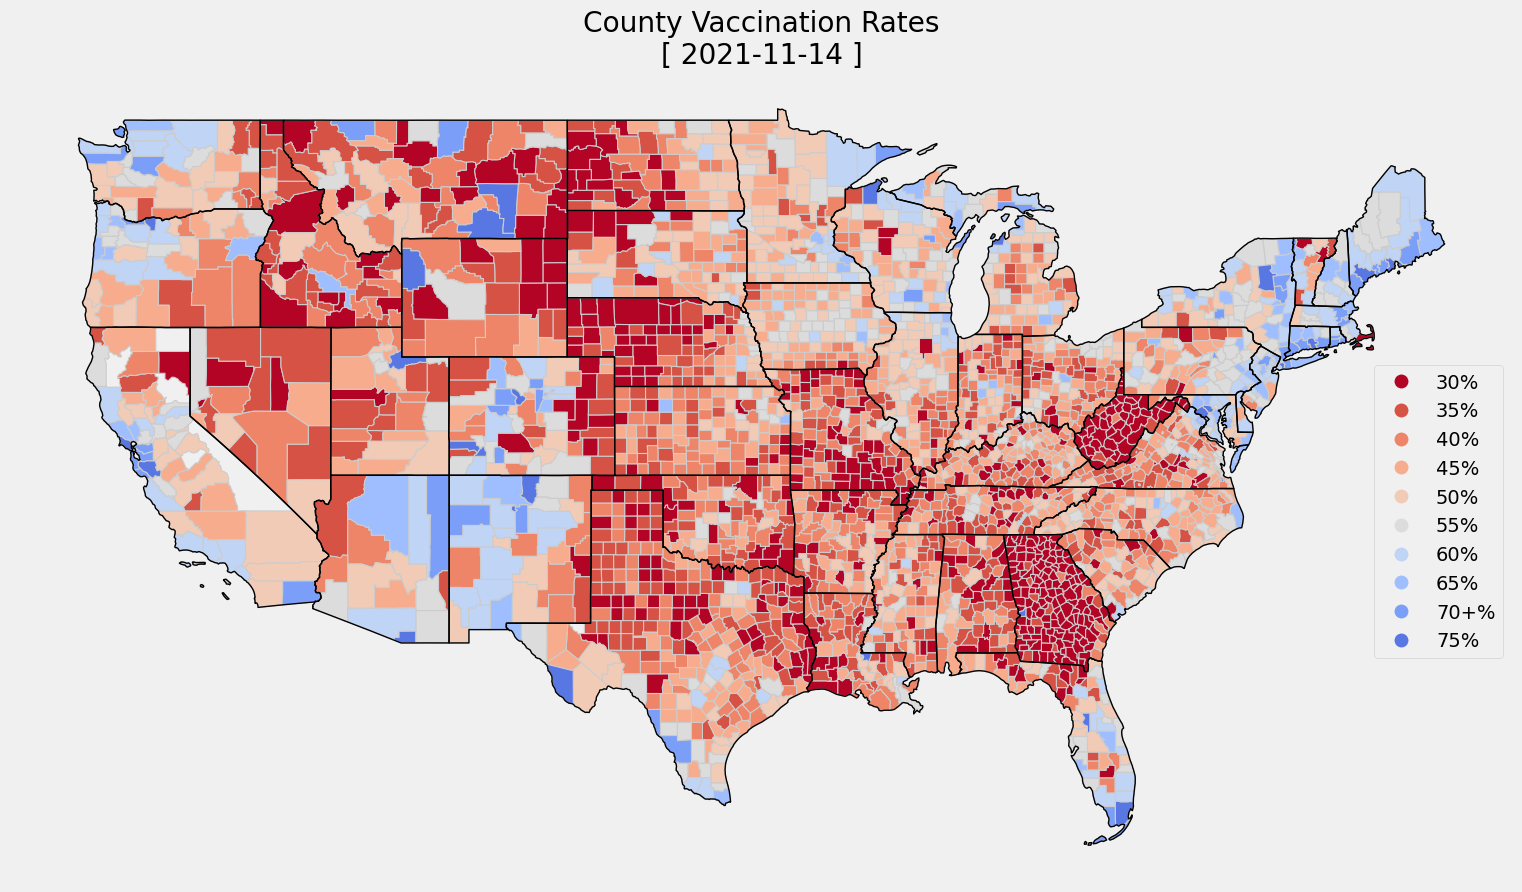

'C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/z_blog_natl_county_vax.jpg'

In [32]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()
fig.set_size_inches(20,10)


leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


outfilename=f'z_blog_natl_county_vax.jpg'
              
#out_blog_images.append(outfilename)
fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")



#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"
copy_path = "wk09_10/"
shutil.copyfile(outfilename, f'{directory_path}{copy_path}{outfilename.split("/")[-1]}')



In [96]:
#//*** Associate County FIPS with a TIER value


base_county_tier = geo_county_tier_df.copy()
del base_county_tier['FIPS']
del base_county_tier['tier']

whole_geo_county_tier_df = pd.DataFrame()
for group  in whole_county_tier_df.groupby('Date'):
    ftd = {
        'tier' : [],
        'FIPS' : []
    }
    
    for row in group[1].iterrows():
        for FIPS in row[1]['FIPS']:
            ftd['tier'].append([row[1]['tier']][0])
            ftd['FIPS'].append(FIPS)
    
        tdf = pd.DataFrame()
        
        
        
        tdf['FIPS'] = ftd['FIPS']
        tdf['tier'] = ftd['tier']
        tdf['Date'] = group[0]
        #print(tdf)
        whole_geo_county_tier_df = pd.concat([whole_geo_county_tier_df, base_county_tier.merge(tdf,left_on="GEOID",right_on="FIPS")])
whole_geo_county_tier_df


STATEFP  GEOID      NAME                                           geometry   FIPS      tier        Date
0          48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...  48459  total_30  2020-02-06
1          45  45021  Cherokee  POLYGON ((-81.87441 35.18352, -81.76813 35.179...  45021  total_30  2020-02-06
2          54  54023     Grant  POLYGON ((-79.48687 39.20596, -79.42441 39.228...  54023  total_30  2020-02-06
3          20  20133    Neosho  POLYGON ((-95.52550 37.73276, -95.08808 37.732...  20133  total_30  2020-02-06
4          29  29175  Randolph  POLYGON ((-92.69723 39.59770, -92.69215 39.610...  29175  total_30  2020-02-06
...       ...    ...       ...                                                ...    ...       ...         ...
3094       22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...  22003  total_30  2021-11-14
3095       38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  38005  total_45  2021-11-14
3096       31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  31159  total_45  2021-11-14
3097       37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  37023  total_40  2021-11-14
3098       13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  13261  total_35  2021-11-14

[14748480 rows x 7 columns]

In [69]:
    #for FIPS in row[1]['FIPS']:
    #    ftd['tier'].append([row[1]['tier']][0])
    #    ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

whole_county_tier_df
county_vax_df
#county_vax_tier_df 

tdf
whole_geo_county_vax_tier_df = county_vax_df.merge(tdf,left_on="FIPS",right_on="FIPS")

geo_county_vax_tier_df

STATEFP  GEOID      NAME                                           geometry
0          37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...
1          37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...
2          39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...
3          42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...
4          48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...
...       ...    ...       ...                                                ...
3094       22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...
3095       38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...
3096       31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...
3097       37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...
3098       13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...

[3099 rows x 4 columns]

In [ ]:
plot_df = geo_county_tier_df.copy()

plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()

exec_fig_width =1280
exec_fig_height=720

plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Blues(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)

vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")

fig = plt.gcf()

DPI = fig.get_dpi()
    #fig = plt.gcf()
    
fig.set_size_inches(exec_fig_width/float(DPI),exec_fig_height/float(DPI))

leg = ax.get_legend()


print(dir(leg.get_figure))
print(dir(leg))



leg.set_bbox_to_anchor((1,0.65,0,0))

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)


outfilename=f'z_blog_natl_county_vax.jpg'
              
#out_blog_images.append(outfilename)
fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")



#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"
copy_path = "wk09_10/"
shutil.copyfile(outfilename, f'{directory_path}{copy_path}{outfilename.split("/")[-1]}')



STATEFP  GEOID      NAME                                           geometry   FIPS      tier
0          37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  37017  total_40
1          37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  37167  total_35
2          39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...  39153  total_55
3          42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...  42113  total_45
4          48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...  48459  total_30
...       ...    ...       ...                                                ...    ...       ...
3094       22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...  22003  total_30
3095       38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...  38005  total_45
3096       31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...  31159  total_45
3097       37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  37023  total_40
3098       13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...  13261  total_35

[3099 rows x 6 columns]

In [34]:
#datetime.strptime(col, "%m/%d/%y").date()
start_summer_date =  datetime(2021, 7, 1).date()
type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_end'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_100k_confirm' : start_summary_df['confirm_period_100k'].astype(int),
    'start_daily_100k_confirm_min' : start_summary_df['confirm_period_100k'].astype(int).min(),
    'start_daily_100k_confirm_max' : start_summary_df['confirm_period_100k'].astype(int).max(),
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days,
    'Population' : start_summary_df['Population'].apply(lambda x: f'{x:,}'),
    
    'pop_pct' : round(start_summary_df['pop_pct']*100,1).astype(str)+"%",
    
    'start_day_count' : start_days,
    'summer_day_count' : summer_days,
    'total_day_count' : start_days + summer_days,
    'us_total_vax' : vax_df['Series_Complete_Pop_Pct'].max(),

}

county_analysis_dict['case_change'] =  round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm']))*100,1)
county_analysis_dict['death_change'] = round(pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death']))*100,1)

county_analysis_dict['case_baseline'] = pd.Series(round( (1- county_analysis_dict['case_change'] /county_analysis_dict['case_change'][0])*100,1))
county_analysis_dict['death_baseline'] = pd.Series(round( (1- county_analysis_dict['death_change']/county_analysis_dict['death_change'][0])*100,1))

county_analysis_dict['case_change'] = county_analysis_dict['case_change'].astype(str)+'%'
county_analysis_dict['death_change'] = county_analysis_dict['death_change'].astype(str)+'%'
"""
print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))
"""
manage_df['county_analysis_dict'] = "Summary Stats for Display for the blog post"
county_analysis_dict

511 136


{'start_daily_100k_confirm': 0    10274
 1    10792
 2    10624
 3    10666
 4    10634
 5     9725
 6    10127
 7     9717
 8     8409
 9    10882
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 8409,
 'start_daily_100k_confirm_max': 10882,
 'start_daily_mean_confirm': 0     3494.203523
 1     3504.575342
 2     4456.716243
 3     6915.772994
 4    11900.727984
 5    10629.571429
 6    13989.342466
 7     4532.330724
 8     3215.765166
 9     2228.287671
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 10     6549.066176
 11     6960.823529
 12     8755.897059
 13    12255.794118
 14    18252.926471
 15    16741.933824
 16    15927.014706
 17     4696.904412
 18     3193.161765
 19     2304.911765
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     67.281800
 1     67.909980
 2     84.052838
 3    121.996086
 4    196.054795
 5    164.133072
 6    269.095890
 7     83.571429
 8     63.716243
 9     44.669276
 Name: con

In [35]:
county_analysis_dict

{'start_daily_100k_confirm': 0    10274
 1    10792
 2    10624
 3    10666
 4    10634
 5     9725
 6    10127
 7     9717
 8     8409
 9    10882
 Name: confirm_period_100k, dtype: int32,
 'start_daily_100k_confirm_min': 8409,
 'start_daily_100k_confirm_max': 10882,
 'start_daily_mean_confirm': 0     3494.203523
 1     3504.575342
 2     4456.716243
 3     6915.772994
 4    11900.727984
 5    10629.571429
 6    13989.342466
 7     4532.330724
 8     3215.765166
 9     2228.287671
 Name: confirm_period, dtype: float64,
 'summer_daily_mean_confirm': 10     6549.066176
 11     6960.823529
 12     8755.897059
 13    12255.794118
 14    18252.926471
 15    16741.933824
 16    15927.014706
 17     4696.904412
 18     3193.161765
 19     2304.911765
 Name: confirm_period, dtype: float64,
 'start_daily_mean_death': 0     67.281800
 1     67.909980
 2     84.052838
 3    121.996086
 4    196.054795
 5    164.133072
 6    269.095890
 7     83.571429
 8     63.716243
 9     44.669276
 Name: con

In [36]:
state_hosp_tiers_df

population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
5983    4157971 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5984    4157971 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5985    4157971 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5986    4157971 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
5987    4157971 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  ID         [16, 54, 56]  total_40        0.0       0.0   
...         ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
3973   13485352 2021-11-10     32404     1607201      7152         81     6119.285714     45.377278        48.714286       0.361239  CT  [9, 23, 25, 44, 50]  total_70    33189.0   28050.0   
3974   13485352 2021-11-11     32410     1609107      5769         36     5978.714286     44.334877        43.571429       0.323102  CT  [9, 23, 25, 44, 50]  total_70    33342.0   28162.0   
3975   13485352 2021-11-12     32433     1614818      7617         29     6057.428571      44.91858        37.000000       0.274372  CT  [9, 23, 25, 44, 50]  total_70    33333.0   28075.0   
3976   13485352 2021-11-13     32443     1616076      6969         33     6438.000000     47.740689        35.142857         0.2606  CT  [9, 23, 25, 44, 50]  total_70    33227.0   27656.0   
3977   13485352 2021-11-14     32443     1616387      1569         10     6466.857143     47.954678        36.000000       0.266956  CT  [9, 23, 25, 44, 50]  total_70    33183.0   27367.0   

     covid_beds_used icu_total            icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
5983             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5984             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5985             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5986             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
5987             0.0       0.0                 0.0       0.0              0.0             0.0              0.0               0.0  
...              ...       ...                 ...       ...              ...             ...              ...               ...  
3973          1155.0    2931.0   0.676863184429305     293.0           1140.0            15.0        45.377278          0.361239  
3974          1170.0    2924.0   0.618018181102465     283.0           1159.0            11.0        44.334877          0.323102  
3975          1182.0    2925.0  0.6315809232581641     291.0           1166.0            16.0         44.91858          0.274372  
3976          1178.0    2912.0   0.629324769381803     286.0           1169.0             9.0        47.740689            0.2606  
3977          1206.0    2908.0   0.611212613505661     285.0           1195.0            11.0        47.954678          0.266956  

[4529 rows x 23 columns]

In [37]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"

manage_df['vax_df'] = "United States Total Vaccine Levels [2020-12-13 - Present]"
vax_df

Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  Administered_Dose1_Recip_12Plus  Administered_Dose1_Recip_12PlusPop_Pct  Administered_Dose1_Recip_18Plus  \
21844 2020-12-13       US                         0                         0.0                                0                                     0.0                                0   
21786 2020-12-14       US                         0                         0.0                                0                                     0.0                                0   
21769 2020-12-15       US                         0                         0.0                                0                                     0.0                                0   
21663 2020-12-16       US                         0                         0.0                                0                                     0.0                                0   
21654 2020-12-17       US                         0                         0.0                                0                                     0.0                                0   
...          ...      ...                       ...                         ...                              ...                                     ...                              ...   
277   2021-11-11       US                 225167371                        67.8                        224376879                                    79.1                        209240859   
248   2021-11-12       US                 225606197                        68.0                        224646990                                    79.2                        209488394   
185   2021-11-13       US                 226157226                        68.1                        224975987                                    79.4                        209794184   
106   2021-11-14       US                 226607653                        68.3                        225254937                                    79.4                        210053318   
61    2021-11-15       US                 227133617                        68.4                        225523235                                    79.5                        210296568   

       Administered_Dose1_Recip_18PlusPop_Pct  Administered_Dose1_Recip_65Plus  Administered_Dose1_Recip_65PlusPop_Pct  Series_Complete_Yes  Series_Complete_Pop_Pct  Series_Complete_12Plus  \
21844                                     0.0                                0                                     0.0                    0                      0.0                       0   
21786                                     0.0                                0                                     0.0                    0                      0.0                       0   
21769                                     0.0                                0                                     0.0                    0                      0.0                       0   
21663                                     0.0                                0                                     0.0                    0                      0.0                       0   
21654                                     0.0                                0                                     0.0                    0                      0.0                       0   
...                                       ...                              ...                                     ...                  ...                      ...                     ...   
277                                      81.0                         54052289                                    98.6            194575146                     58.6               194438211   
248                                      81.1                         54120621                                    98.8            194747839                     58.7               194610776   
185            

- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [38]:
#plt.get_cmap("Blues")
#//*** Assign Categories for color palettes
plot_cats = geo_county_tier_df['tier'].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


alt_colors = {}
counter = 0
for period in plot_cats:
    alt_colors[period] = colors_palette[counter]
    counter+=1
    
alt_colors


{'total_40': (0.705673158, 0.01555616, 0.150232812, 1.0),
 'total_35': (0.8393649370784314,
  0.32185622094117644,
  0.26492398098039216,
  1.0),
 'total_55': (0.9318312966, 0.5190855232, 0.4064796086, 1.0),
 'total_45': (0.9684997476666667, 0.673977379772549, 0.5566492560470588, 1.0),
 'total_30': (0.9473454036, 0.7946955048, 0.7169905058, 1.0),
 'total_50': (0.8674276350862745, 0.864376599772549, 0.8626024620196079, 1.0),
 'total_75': (0.753610618, 0.830232851, 0.960871157, 1.0),
 'total_60': (0.6193179451882354, 0.7441207347647059, 0.9989309188196078, 1.0),
 'total_65': (0.48385432959999997, 0.6220498496, 0.9748082026, 1.0),
 'total_70': (0.34832334141176474,
  0.4657111465098039,
  0.8883461629411764,
  1.0)}

In [39]:
#tier.replace("total_","")+"%"
colors
if 'geometry' not in geo_county_vax_tier_df.columns:
    print("Merge Geo Data with vax")


    geo_county_vax_tier_df = geo_county_tier_df[["STATEFP","GEOID","geometry"]].merge(geo_county_vax_tier_df,left_on='GEOID',right_on='FIPS')

Merge Geo Data with vax


In [40]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:
        
        if datetime.strptime(date, "%m/%d/%y").date() < start_plot_date:
            continue
        #print(date)
        #if date != "1/13/21":
        #    continue
        
        file_counter += 1
        
        #if file_counter % 50 > 0:
        #    continue

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        death_filename = f"{filepath}death_hist_{file_counter}.jpg"
        vax_filename = f"{filepath}vax_hist_{file_counter}.jpg"
        
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                #print(f"Skipping: {save_filename}")
                out_controls['copy_files']['infographic_cases'].append(save_filename)
                out_controls['copy_files']['infographic_cases'].append(death_filename)
                out_controls['copy_files']['infographic_cases'].append(vax_filename)
                
                continue

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,4)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_confirm_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(save_filename)
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        attrib_death_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(death_filename)
        print(death_filename)
        plt.savefig(death_filename,pil_kwargs={'quality': 90})

        plt.close()
        

        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=70))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"Completed Vaccination",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        out_controls['copy_files']['infographic_cases'].append(vax_filename)
        print(vax_filename)
        plt.savefig(vax_filename,pil_kwargs={'quality': 95})

        plt.close()



    print("Done...")
plt.rcdefaults()

print("Done!")

Working...
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/confirm_hist_647.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/death_hist_647.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/vax_hist_647.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/confirm_hist_648.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/death_hist_648.jpg
C:/Users/stonk013/DSC/DSC640/project/infographic_confirm/vax_hist_648.jpg
Done...
Done!


In [41]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")



#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "kstoneburner.github.io/DSC640/"

"""
for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")
"""

for key,action in out_controls.items():
    
    
    if key == 'copy_files':
        
        for action_key,action_values in action.items():
            if action_key == "infographic_cases":
                copy_path = "wk09_10/infographic_gifs/"
                
                for filename in action_values:
                    try:
                        print(f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                        shutil.copyfile(filename, f'{directory_path}{copy_path}{filename.split("/")[-1]}')
                    except:
                        continue
                

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_1.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_2.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_3.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_4.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_4.jpg
C:/Users

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_49.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_49.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_49.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_50.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_50.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_50.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_51.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_51.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_51.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_52.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_52.j

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_115.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_116.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_116.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_116.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_117.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_117.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_117.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_118.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_118.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_118.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_183.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_184.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_184.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_184.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_185.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_185.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_185.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_186.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_186.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_186.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_216.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_216.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_216.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_217.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_217.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_217.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_218.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_218.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_218.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_219.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_255.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_255.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_255.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_256.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_256.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_256.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_257.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_257.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_257.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_258.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_287.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_288.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_288.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_288.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_289.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_289.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_289.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_290.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_290.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_290.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_h

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_327.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_327.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_328.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_328.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_328.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_329.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_329.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_329.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_330.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_330.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_381.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_381.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_381.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_382.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_382.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_382.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_383.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_383.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_383.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_384.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_434.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_434.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_435.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_435.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_435.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_436.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_436.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_436.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_437.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_437.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_488.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_488.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_489.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_489.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_489.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_490.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_490.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_490.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_491.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_491.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_548.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_548.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_549.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_549.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_549.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_550.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_550.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_550.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_551.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_551.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_600.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_600.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_601.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_601.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_601.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_602.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_602.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_hist_602.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/confirm_hist_603.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/death_hist_603.jpg
C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_gifs/vax_his

In [42]:
all_dates

['1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5/20',
 '4/6/20',
 '4/7/20',
 '4/8/20',
 '4/9/20',
 '4/10/20',
 '4/11/20',
 '4/12/20',
 '4/13/20',
 '4/14/20',
 '4/15/20',
 '4/16/20',
 '4/17/20',
 '4/18/20',
 '4/19/20',
 '4/20/20',
 '4/21/20',
 '4/22/20',
 '4/23/

Working...


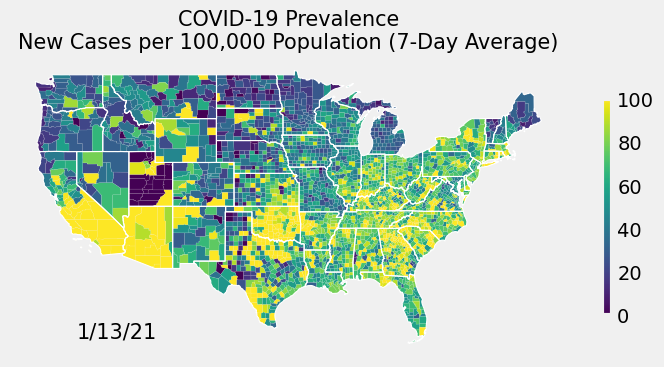

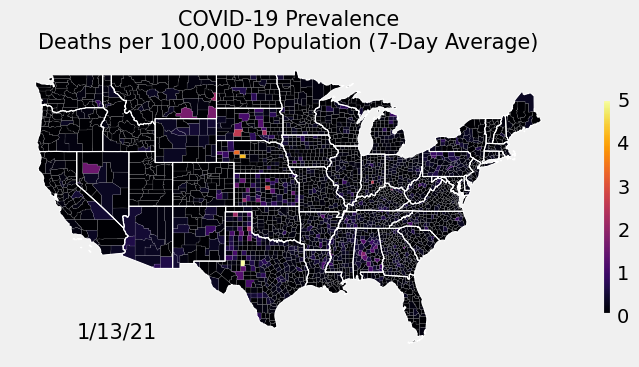

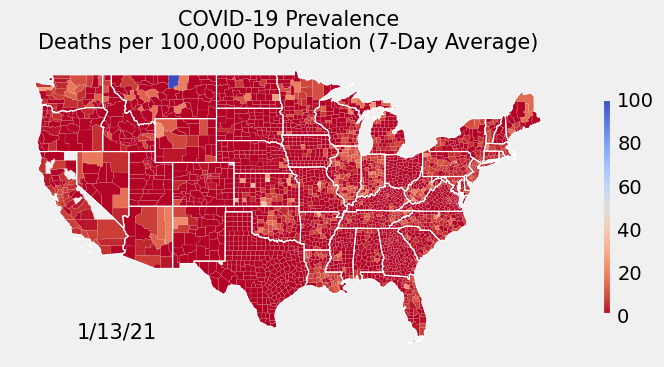

Done...
Done!


In [43]:
#2021/01/13


("1/13/21" in all_dates)



#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False
plt.rcdefaults()
plt.style.use('fivethirtyeight')
if 'copy_files' not in out_controls.keys():
    out_controls['copy_files'] = {}

out_controls['copy_files']['infographic_cases'] = []
start_plot_date =  datetime(2020, 2, 6).date()
#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if True:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/infographic_confirm/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=15

    dates = all_dates[100:]
    #dates = all_dates[-30:]
    dates = all_dates

    first=True

    file_counter = 0
    print("Working...")
    for date in ["1/13/21"]:
        

        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************


        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************

        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "viridis"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.plasma(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm = plt.cm.ScalarMappable(cmap=plt.inferno(), norm=plt.Normalize(vmin=0, vmax=100))
        #sm2 = plt.cm.ScalarMappable(cmap=plt.get_cmap("viridis"), norm=plt.Normalize(vmin=0, vmax=100))
        #plt.get_cmap
        
        
        #colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.savefig("test.jpg",pil_kwargs={'quality': 95})
        plt.show()
        
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
        plot_df = attrib_death_df.copy()
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "inferno"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()
     #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        #//*********************************************************************************
        
                
        vax_plot_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]
        
        if len(vax_plot_df) == 0:
            continue
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8,3.8)
        #fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        color_map = "coolwarm_r"
        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(color_map), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []

        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        vax_plot_df.plot(column='total_vaccinated_percent', ax=ax,linewidth=0.3,cmap=plt.get_cmap(color_map),edgecolor=(1,1,1,.2))
        
        
        #//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
        ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=.8,edgecolor='white',color=(1,1,1,0),ax=ax)
        
        plt.title(f"COVID-19 Prevalence\nDeaths per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        #plt.viridis()

        plt.show()



    print("Done...")
plt.rcdefaults()

print("Done!")

In [44]:
"""
linewidth=.2
counter = 0
for tier in geo_county_tier_df['tier'].unique():
    counter += 1
    temp_plot = geo_county_tier_df[geo_county_tier_df['tier'] == tier]

    if counter > 3:
        linewidth+=.2


    ax = temp_plot.plot(categorical=True,legend=True, linewidth=linewidth,edgecolor=alt_colors[tier],color=(1,1,1,0),ax=ax)

#geo_county_tier_df

temp_plot = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == datetime.strptime(date, "%m/%d/%y").date()]

if len(temp_plot) > 0:
    #ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, linewidth=linewidth,cmap=plt.get_cmap("viridis"),color=(1,1,1,0),ax=ax)
    ax = temp_plot.plot(column="total_vaccinated_count",categorical=True,legend=True, marker='.', linewidth=linewidth,cmap=plt.get_cmap("Blues"),markersize=1,ax=ax)
"""

geo_county_vax_tier_df
print(attrib_death_df)

     STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Deaths  1/29/20_New_Deaths_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   0                            0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                   0                            0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                   0                            0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   0                            0   
4         48  48459    Up

In [45]:
attrib_confirm_df['1/5/21_scaled_100k'].max()

100

In [46]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
#out_plot['confirm_historical'] = out_html

In [47]:
county_tier_df

Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
334  2020-12-21  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849      968563      16521       15589        104    21784.285714   
335  2020-12-22  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849      981752      16720       19945        244    21887.428571   
336  2020-12-23  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849      993854      16901       25291        380    22036.285714   
337  2020-12-24  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849     1007761      17069       26009        349    22209.000000   
338  2020-12-25  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849     1015400      17161       21546        260    21502.714286   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
658  2021-11-10  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1447838      23468        1815         16     2326.000000   
659  2021-11-11  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1448495      23469        1643          8     2300.714286   
660  2021-11-12  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k total_vaccinated_percent total_vaccinated_count first_dose_pct first_dose_count      tier  
334       263.857143    125.349416       1.518266              100          1.518266                      0.0                      0            0.0              0.0  total_30  
335       263.571429    125.942912       1.516622              100          1.516622                      0.0                      0            0.0              0.0  total_30  
336       267.714286    126.799454        1.54046              100           1.54046                      0.0                      0            0.0              0.0  total_30  
337       266.714286    127.793273       1.534706              100          1.534706                      0.0                      0            0.0              0.0  total_30  
338       261.000000     123.72922       1.501826              100          1.501826                      0.0                      0            0.0              0.0  total_30  
..               ...           ...            ...              ...               ...                      ...                    ...            ...              ...       ...  
658        16.857143     22.229488       0.161103        22.229488          0.161103                76.576131                8012604      86.814827        9083938.0  total_75  
659        14.428571     21.987833       0.137893        21.987833          0.137893                 76.64865                8020192      86.960752        9099207.0  total_75  
660        10.714286     21.676549       0.102396        21.676549          0

- [Graph: Infographic Visualization](#infographic_visualization)


<a id="infographic_visualization"></a> 
# Graph: Infographic Visualization #

In [48]:
geo_county_vax_tier_df['Date'].iloc[1]

datetime.date(2021, 11, 13)

In [49]:
import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()
    
out_master = {}

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily","total_vaccinated_percent"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in whole_county_tier_df['Date'].unique():
    #if date >= start_summer_date:
    #    break
    loop_df = whole_county_tier_df[whole_county_tier_df['Date'] == date].copy()
    loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date].copy()
    
   
    
    
    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_confirm)
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                
                case_100k_avg_daily = round(tot_confirm / (pop / 100000),4)
                case_100k_avg_daily = round(case_100k_avg_daily / days,4)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,2)
                td[col].append(death_100k_avg_daily)
                continue
                
            if col == "total_vaccinated_percent":
                #//**** No Vaccaination Data Yet
                #loop_vax_df = geo_county_vax_tier_df[geo_county_vax_tier_df['Date'] == date]
                #total_vaccinated_percent = "0%"
                #td[col].append("0%")
                if len(loop_vax_df) == 0:
                    total_vaccinated_percent = "0.0%"
                    td[col].append("0%")
                else:
                    #print(geo_county_vax_tier_df)
                    
                    total_vaccinated_percent = loop_vax_df[loop_vax_df['tier'] == tier][col].values[0]
                    total_vaccinated_percent = str(total_vaccinated_percent) + "%"
                    td[col].append(total_vaccinated_percent)
                continue

    #print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm,total_vaccinated_percent)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['New_Confirm'][x],td['tier'][x],td['case_100k_avg'][x],td["relative_confirm_100k"][x],td['total_vaccinated_percent'][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_left'] = {
    'filename' : 'infographic_left.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_left = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
last_date = td['Date'][-1]
print("Done!")

0 2020/02/06 total_30 0 total_30 0.0 0% 0%
1 2020/02/06 total_35 0 total_35 0.0 0% 0%
2 2020/02/06 total_40 0 total_40 0.0 0% 0%
3 2020/02/06 total_45 0 total_45 0.0 0% 0%
4 2020/02/06 total_50 0 total_50 0.0 0% 0%
5 2020/02/06 total_55 0 total_55 0.0 0% 0%
6 2020/02/06 total_60 1 total_60 0.0014 0% 0%
7 2020/02/06 total_65 0 total_65 0.0 0% 0%
8 2020/02/06 total_70 0 total_70 0.0 0% 0%
9 2020/02/06 total_75 0 total_75 0.0 0% 0%
10 2020/02/07 total_30 0 total_30 0.0 0% 0%
11 2020/02/07 total_35 0 total_35 0.0 0% 0%
12 2020/02/07 total_40 0 total_40 0.0 0% 0%
13 2020/02/07 total_45 0 total_45 0.0 0% 0%
14 2020/02/07 total_50 0 total_50 0.0 0% 0%
15 2020/02/07 total_55 0 total_55 0.0 0% 0%
16 2020/02/07 total_60 1 total_60 0.0014 0% 0%
17 2020/02/07 total_65 0 total_65 0.0 0% 0%
18 2020/02/07 total_70 0 total_70 0.0 0% 0%
19 2020/02/07 total_75 0 total_75 0.0 0% 0%
20 2020/02/08 total_30 0 total_30 0.0 0% 0%
21 2020/02/08 total_35 0 total_35 0.0 0% 0%
22 2020/02/08 total_40 0 total_40 0.

280 2020/03/05 total_30 0 total_30 0.0 0% 0%
281 2020/03/05 total_35 0 total_35 0.0 0% 0%
282 2020/03/05 total_40 0 total_40 0.0 0% 0%
283 2020/03/05 total_45 1 total_45 0.003 0% 0%
284 2020/03/05 total_50 4 total_50 0.007 0% 0%
285 2020/03/05 total_55 4 total_55 0.0072 0% 0%
286 2020/03/05 total_60 27 total_60 0.0383 0% 0%
287 2020/03/05 total_65 7 total_65 0.0294 0% 0%
288 2020/03/05 total_70 57 total_70 0.2917 0% 0%
289 2020/03/05 total_75 5 total_75 0.0478 0% 0%
290 2020/03/06 total_30 1 total_30 0.0058 100.0% 0%
291 2020/03/06 total_35 0 total_35 0.0 0.0% 0%
292 2020/03/06 total_40 0 total_40 0.0 0.0% 0%
293 2020/03/06 total_45 1 total_45 0.003 51.72% 0%
294 2020/03/06 total_50 7 total_50 0.0122 210.34% 0%
295 2020/03/06 total_55 11 total_55 0.0197 339.66% 0%
296 2020/03/06 total_60 26 total_60 0.0368 634.48% 0%
297 2020/03/06 total_65 14 total_65 0.0587 1012.07% 0%
298 2020/03/06 total_70 60 total_70 0.307 5293.1% 0%
299 2020/03/06 total_75 14 total_75 0.1338 2306.9% 0%
300 2020/

541 2020/03/31 total_35 640 total_35 3.8569 43.55% 0%
542 2020/03/31 total_40 935 total_40 4.362 49.26% 0%
543 2020/03/31 total_45 2732 total_45 8.2456 93.11% 0%
544 2020/03/31 total_50 3857 total_50 6.7449 76.17% 0%
545 2020/03/31 total_55 5611 total_55 10.0466 113.45% 0%
546 2020/03/31 total_60 14485 total_60 20.5211 231.73% 0%
547 2020/03/31 total_65 5718 total_65 23.9918 270.92% 0%
548 2020/03/31 total_70 7192 total_70 36.8048 415.61% 0%
549 2020/03/31 total_75 4720 total_75 45.1088 509.38% 0%
550 2020/04/01 total_30 1654 total_30 9.5173 100.0% 0%
551 2020/04/01 total_35 759 total_35 4.574 48.06% 0%
552 2020/04/01 total_40 1137 total_40 5.3043 55.73% 0%
553 2020/04/01 total_45 3314 total_45 10.0022 105.09% 0%
554 2020/04/01 total_50 3918 total_50 6.8515 71.99% 0%
555 2020/04/01 total_55 6484 total_55 11.6098 121.99% 0%
556 2020/04/01 total_60 19740 total_60 27.966 293.84% 0%
557 2020/04/01 total_65 6461 total_65 27.1093 284.84% 0%
558 2020/04/01 total_70 8021 total_70 41.0471 431.2

808 2020/04/26 total_70 6397 total_70 32.7364 445.86% 0%
809 2020/04/26 total_75 3101 total_75 29.6361 403.64% 0%
810 2020/04/27 total_30 1351 total_30 7.7738 100.0% 0%
811 2020/04/27 total_35 1288 total_35 7.7619 99.85% 0%
812 2020/04/27 total_40 2484 total_40 11.5884 149.07% 0%
813 2020/04/27 total_45 2908 total_45 8.7768 112.9% 0%
814 2020/04/27 total_50 4300 total_50 7.5195 96.73% 0%
815 2020/04/27 total_55 6554 total_55 11.7351 150.96% 0%
816 2020/04/27 total_60 16277 total_60 23.0599 296.64% 0%
817 2020/04/27 total_65 6416 total_65 26.9205 346.3% 0%
818 2020/04/27 total_70 5527 total_70 28.2842 363.84% 0%
819 2020/04/27 total_75 2913 total_75 27.8394 358.12% 0%
820 2020/04/28 total_30 1736 total_30 9.9892 100.0% 0%
821 2020/04/28 total_35 1402 total_35 8.4489 84.58% 0%
822 2020/04/28 total_40 2374 total_40 11.0752 110.87% 0%
823 2020/04/28 total_45 2831 total_45 8.5444 85.54% 0%
824 2020/04/28 total_50 4838 total_50 8.4604 84.7% 0%
825 2020/04/28 total_55 6932 total_55 12.4119 12

1071 2020/05/23 total_35 1719 total_35 10.3593 103.95% 0%
1072 2020/05/23 total_40 1917 total_40 8.9432 89.74% 0%
1073 2020/05/23 total_45 3456 total_45 10.4307 104.66% 0%
1074 2020/05/23 total_50 5420 total_50 9.4781 95.1% 0%
1075 2020/05/23 total_55 7519 total_55 13.463 135.09% 0%
1076 2020/05/23 total_60 13128 total_60 18.5986 186.62% 0%
1077 2020/05/23 total_65 4831 total_65 20.2701 203.39% 0%
1078 2020/05/23 total_70 2497 total_70 12.7783 128.22% 0%
1079 2020/05/23 total_75 1725 total_75 16.4858 165.42% 0%
1080 2020/05/24 total_30 1762 total_30 10.1388 100.0% 0%
1081 2020/05/24 total_35 1536 total_35 9.2564 91.3% 0%
1082 2020/05/24 total_40 1854 total_40 8.6493 85.31% 0%
1083 2020/05/24 total_45 3046 total_45 9.1933 90.67% 0%
1084 2020/05/24 total_50 5351 total_50 9.3575 92.29% 0%
1085 2020/05/24 total_55 6142 total_55 10.9974 108.47% 0%
1086 2020/05/24 total_60 12580 total_60 17.8223 175.78% 0%
1087 2020/05/24 total_65 4226 total_65 17.7316 174.89% 0%
1088 2020/05/24 total_70 234

1325 2020/06/17 total_55 8192 total_55 14.668 88.82% 0%
1326 2020/06/17 total_60 12133 total_60 17.189 104.09% 0%
1327 2020/06/17 total_65 1974 total_65 8.2826 50.15% 0%
1328 2020/06/17 total_70 1731 total_70 8.8583 53.64% 0%
1329 2020/06/17 total_75 1871 total_75 17.8811 108.28% 0%
1330 2020/06/18 total_30 2870 total_30 16.5143 100.0% 0%
1331 2020/06/18 total_35 3728 total_35 22.4662 136.04% 0%
1332 2020/06/18 total_40 2875 total_40 13.4124 81.22% 0%
1333 2020/06/18 total_45 5328 total_45 16.0807 97.37% 0%
1334 2020/06/18 total_50 11949 total_50 20.8956 126.53% 0%
1335 2020/06/18 total_55 9592 total_55 17.1747 104.0% 0%
1336 2020/06/18 total_60 12968 total_60 18.372 111.25% 0%
1337 2020/06/18 total_65 2153 total_65 9.0336 54.7% 0%
1338 2020/06/18 total_70 1833 total_70 9.3803 56.8% 0%
1339 2020/06/18 total_75 2000 total_75 19.1139 115.74% 0%
1340 2020/06/19 total_30 2912 total_30 16.756 100.0% 0%
1341 2020/06/19 total_35 2956 total_35 17.8138 106.31% 0%
1342 2020/06/19 total_40 2812 t

1603 2020/07/15 total_45 14662 total_45 44.2522 93.96% 0%
1604 2020/07/15 total_50 30669 total_50 53.6318 113.87% 0%
1605 2020/07/15 total_55 21144 total_55 37.8589 80.38% 0%
1606 2020/07/15 total_60 27377 total_60 38.7854 82.35% 0%
1607 2020/07/15 total_65 4941 total_65 20.7316 44.02% 0%
1608 2020/07/15 total_70 3405 total_70 17.4249 37.0% 0%
1609 2020/07/15 total_75 6007 total_75 57.4087 121.89% 0%
1610 2020/07/16 total_30 8768 total_30 50.4521 100.0% 0%
1611 2020/07/16 total_35 8035 total_35 48.4215 95.98% 0%
1612 2020/07/16 total_40 8638 total_40 40.298 79.87% 0%
1613 2020/07/16 total_45 14994 total_45 45.2542 89.7% 0%
1614 2020/07/16 total_50 29263 total_50 51.1731 101.43% 0%
1615 2020/07/16 total_55 22245 total_55 39.8302 78.95% 0%
1616 2020/07/16 total_60 34806 total_60 49.3102 97.74% 0%
1617 2020/07/16 total_65 5793 total_65 24.3065 48.18% 0%
1618 2020/07/16 total_70 3199 total_70 16.3707 32.45% 0%
1619 2020/07/16 total_75 6949 total_75 66.4113 131.63% 0%
1620 2020/07/17 total_

1861 2020/08/10 total_35 5399 total_35 32.5361 89.91% 0%
1862 2020/08/10 total_40 6255 total_40 29.1808 80.64% 0%
1863 2020/08/10 total_45 10211 total_45 30.8184 85.16% 0%
1864 2020/08/10 total_50 20725 total_50 36.2425 100.15% 0%
1865 2020/08/10 total_55 13387 total_55 23.9698 66.24% 0%
1866 2020/08/10 total_60 17454 total_60 24.7274 68.33% 0%
1867 2020/08/10 total_65 3850 total_65 16.154 44.64% 0%
1868 2020/08/10 total_70 2740 total_70 14.0218 38.75% 0%
1869 2020/08/10 total_75 4098 total_75 39.1644 108.23% 0%
1870 2020/08/11 total_30 7227 total_30 41.585 100.0% 0%
1871 2020/08/11 total_35 5930 total_35 35.7361 85.94% 0%
1872 2020/08/11 total_40 6340 total_40 29.5774 71.13% 0%
1873 2020/08/11 total_45 11271 total_45 34.0176 81.8% 0%
1874 2020/08/11 total_50 21032 total_50 36.7793 88.44% 0%
1875 2020/08/11 total_55 14118 total_55 25.2786 60.79% 0%
1876 2020/08/11 total_60 16849 total_60 23.8702 57.4% 0%
1877 2020/08/11 total_65 4636 total_65 19.4519 46.78% 0%
1878 2020/08/11 total_70 

2121 2020/09/05 total_35 6188 total_35 37.2909 98.0% 0%
2122 2020/09/05 total_40 8143 total_40 37.9887 99.83% 0%
2123 2020/09/05 total_45 11535 total_45 34.8144 91.49% 0%
2124 2020/09/05 total_50 16863 total_50 29.4889 77.5% 0%
2125 2020/09/05 total_55 17059 total_55 30.5446 80.27% 0%
2126 2020/09/05 total_60 15159 total_60 21.476 56.44% 0%
2127 2020/09/05 total_65 4581 total_65 19.2211 50.51% 0%
2128 2020/09/05 total_70 2732 total_70 13.9809 36.74% 0%
2129 2020/09/05 total_75 2515 total_75 24.0358 63.17% 0%
2130 2020/09/06 total_30 5611 total_30 32.2864 100.0% 0%
2131 2020/09/06 total_35 5114 total_35 30.8186 95.45% 0%
2132 2020/09/06 total_40 6565 total_40 30.627 94.86% 0%
2133 2020/09/06 total_45 8384 total_45 25.3042 78.37% 0%
2134 2020/09/06 total_50 13681 total_50 23.9244 74.1% 0%
2135 2020/09/06 total_55 12865 total_55 23.0351 71.35% 0%
2136 2020/09/06 total_60 11710 total_60 16.5897 51.38% 0%
2137 2020/09/06 total_65 3925 total_65 16.4687 51.01% 0%
2138 2020/09/06 total_70 2320

2393 2020/10/02 total_45 12712 total_45 38.3668 100.93% 0%
2394 2020/10/02 total_50 16910 total_50 29.571 77.79% 0%
2395 2020/10/02 total_55 19563 total_55 35.028 92.15% 0%
2396 2020/10/02 total_60 15058 total_60 21.3329 56.12% 0%
2397 2020/10/02 total_65 5325 total_65 22.3428 58.78% 0%
2398 2020/10/02 total_70 3039 total_70 15.552 40.91% 0%
2399 2020/10/02 total_75 2231 total_75 21.3216 56.09% 0%
2400 2020/10/03 total_30 6942 total_30 39.9451 100.0% 0%
2401 2020/10/03 total_35 7814 total_35 47.0897 117.89% 0%
2402 2020/10/03 total_40 9698 total_40 45.2431 113.26% 0%
2403 2020/10/03 total_45 12479 total_45 37.6635 94.29% 0%
2404 2020/10/03 total_50 18068 total_50 31.5961 79.1% 0%
2405 2020/10/03 total_55 19840 total_55 35.524 88.93% 0%
2406 2020/10/03 total_60 16247 total_60 23.0174 57.62% 0%
2407 2020/10/03 total_65 5257 total_65 22.0575 55.22% 0%
2408 2020/10/03 total_70 3178 total_70 16.2633 40.71% 0%
2409 2020/10/03 total_75 2290 total_75 21.8854 54.79% 0%
2410 2020/10/04 total_30 

2655 2020/10/28 total_55 27878 total_55 49.9163 113.63% 0%
2656 2020/10/28 total_60 27477 total_60 38.9271 88.62% 0%
2657 2020/10/28 total_65 11566 total_65 48.529 110.48% 0%
2658 2020/10/28 total_70 5509 total_70 28.1921 64.18% 0%
2659 2020/10/28 total_75 2846 total_75 27.1991 61.92% 0%
2660 2020/10/29 total_30 7779 total_30 44.7613 100.0% 0%
2661 2020/10/29 total_35 10990 total_35 66.2293 147.96% 0%
2662 2020/10/29 total_40 14976 total_40 69.866 156.09% 0%
2663 2020/10/29 total_45 21316 total_45 64.335 143.73% 0%
2664 2020/10/29 total_50 30105 total_50 52.6456 117.61% 0%
2665 2020/10/29 total_55 29166 total_55 52.2225 116.67% 0%
2666 2020/10/29 total_60 30766 total_60 43.5867 97.38% 0%
2667 2020/10/29 total_65 12730 total_65 53.413 119.33% 0%
2668 2020/10/29 total_70 6512 total_70 33.3249 74.45% 0%
2669 2020/10/29 total_75 2774 total_75 26.511 59.23% 0%
2670 2020/10/30 total_30 8681 total_30 49.9515 100.0% 0%
2671 2020/10/30 total_35 12470 total_35 75.1483 150.44% 0%
2672 2020/10/30 

2947 2020/11/26 total_65 21648 total_65 90.8314 102.76% 0%
2948 2020/11/26 total_70 13600 total_70 69.5974 78.74% 0%
2949 2020/11/26 total_75 5924 total_75 56.6154 64.05% 0%
2950 2020/11/27 total_30 14121 total_30 81.2539 100.0% 0%
2951 2020/11/27 total_35 18404 total_35 110.9085 136.5% 0%
2952 2020/11/27 total_40 25247 total_40 117.7823 144.96% 0%
2953 2020/11/27 total_45 35097 total_45 105.9282 130.37% 0%
2954 2020/11/27 total_50 54435 total_50 95.1922 117.15% 0%
2955 2020/11/27 total_55 57137 total_55 102.3052 125.91% 0%
2956 2020/11/27 total_60 61996 total_60 87.8307 108.09% 0%
2957 2020/11/27 total_65 23124 total_65 97.0245 119.41% 0%
2958 2020/11/27 total_70 13514 total_70 69.1573 85.11% 0%
2959 2020/11/27 total_75 8030 total_75 76.7424 94.45% 0%
2960 2020/11/28 total_30 12977 total_30 74.6712 100.0% 0%
2961 2020/11/28 total_35 19977 total_35 120.388 161.22% 0%
2962 2020/11/28 total_40 26440 total_40 123.3479 165.19% 0%
2963 2020/11/28 total_45 42767 total_45 129.0774 172.86% 0%


3213 2020/12/23 total_45 45864 total_45 138.4246 95.12% 0.0%
3214 2020/12/23 total_50 81442 total_50 142.4202 97.86% 0.0%
3215 2020/12/23 total_55 59357 total_55 106.2802 73.03% 0.0%
3216 2020/12/23 total_60 99472 total_60 140.9236 96.84% 0.0%
3217 2020/12/23 total_65 23274 total_65 97.6539 67.1% 0.0%
3218 2020/12/23 total_70 19195 total_70 98.2296 67.5% 0.0%
3219 2020/12/23 total_75 11900 total_75 113.7278 78.15% 0.0%
3220 2020/12/24 total_30 26009 total_30 149.6589 100.0% 0.0%
3221 2020/12/24 total_35 23657 total_35 142.5648 95.26% 0.0%
3222 2020/12/24 total_40 29966 total_40 139.7973 93.41% 0.0%
3223 2020/12/24 total_45 44090 total_45 133.0704 88.92% 0.0%
3224 2020/12/24 total_50 84985 total_50 148.6159 99.3% 0.0%
3225 2020/12/24 total_55 59965 total_55 107.3688 71.74% 0.0%
3226 2020/12/24 total_60 98824 total_60 140.0055 93.55% 0.0%
3227 2020/12/24 total_65 26293 total_65 110.3211 73.72% 0.0%
3228 2020/12/24 total_70 21071 total_70 107.8299 72.05% 0.0%
3229 2020/12/24 total_75 1263

3461 2021/01/17 total_35 18702 total_35 112.7044 101.78% 0.0%
3462 2021/01/17 total_40 24231 total_40 113.0424 102.09% 0.4%
3463 2021/01/17 total_45 36604 total_45 110.4765 99.77% 0.0%
3464 2021/01/17 total_50 77392 total_50 135.3378 122.22% 0.0%
3465 2021/01/17 total_55 56904 total_55 101.888 92.01% 0.1%
3466 2021/01/17 total_60 87261 total_60 123.624 111.64% 0.3%
3467 2021/01/17 total_65 24576 total_65 103.1168 93.12% 0.9%
3468 2021/01/17 total_70 19844 total_70 101.5508 91.71% 0.0%
3469 2021/01/17 total_75 13908 total_75 132.9182 120.04% 0.0%
3470 2021/01/18 total_30 14124 total_30 81.2712 100.0% 0.0%
3471 2021/01/18 total_35 13514 total_35 81.4398 100.21% 0.0%
3472 2021/01/18 total_40 18693 total_40 87.2066 107.3% 0.4%
3473 2021/01/18 total_45 27564 total_45 83.1924 102.36% 0.0%
3474 2021/01/18 total_50 62750 total_50 109.7329 135.02% 0.0%
3475 2021/01/18 total_55 44965 total_55 80.511 99.06% 0.1%
3476 2021/01/18 total_60 74135 total_60 105.0282 129.23% 0.3%
3477 2021/01/18 total_6

3723 2021/02/12 total_45 22820 total_45 68.8743 104.34% 3.2%
3724 2021/02/12 total_50 35505 total_50 62.0887 94.06% 4.2%
3725 2021/02/12 total_55 34020 total_55 60.9137 92.28% 2.3%
3726 2021/02/12 total_60 43898 total_60 62.191 94.21% 2.6%
3727 2021/02/12 total_65 14387 total_65 60.3655 91.45% 4.7%
3728 2021/02/12 total_70 10734 total_70 54.9308 83.21% 3.0%
3729 2021/02/12 total_75 7814 total_75 74.6781 113.13% 0.0%
3730 2021/02/13 total_30 10591 total_30 60.9419 100.0% 0.0%
3731 2021/02/13 total_35 9925 total_35 59.8113 98.14% 2.7%
3732 2021/02/13 total_40 12808 total_40 59.7519 98.05% 7.4%
3733 2021/02/13 total_45 20055 total_45 60.5291 99.32% 3.2%
3734 2021/02/13 total_50 31170 total_50 54.5079 89.44% 4.4%
3735 2021/02/13 total_55 31701 total_55 56.7614 93.14% 2.4%
3736 2021/02/13 total_60 40429 total_60 57.2764 93.99% 2.9%
3737 2021/02/13 total_65 13213 total_65 55.4396 90.97% 5.0%
3738 2021/02/13 total_70 10312 total_70 52.7712 86.59% 5.4%
3739 2021/02/13 total_75 7731 total_75 73

4004 2021/03/12 total_50 28690 total_50 50.1711 47.27% 12.2%
4005 2021/03/12 total_55 29309 total_55 52.4785 49.45% 7.7%
4006 2021/03/12 total_60 29178 total_60 41.3369 38.95% 7.8%
4007 2021/03/12 total_65 9242 total_65 38.7779 36.54% 18.3%
4008 2021/03/12 total_70 7093 total_70 36.2981 34.2% 16.8%
4009 2021/03/12 total_75 5877 total_75 56.1663 52.92% 4.7%
4010 2021/03/13 total_30 4153 total_30 23.8969 100.0% 0.0%
4011 2021/03/13 total_35 4546 total_35 27.3957 114.64% 8.1%
4012 2021/03/13 total_40 6057 total_40 28.2571 118.25% 12.4%
4013 2021/03/13 total_45 11239 total_45 33.921 141.95% 13.4%
4014 2021/03/13 total_50 16928 total_50 29.6025 123.88% 12.7%
4015 2021/03/13 total_55 19572 total_55 35.0442 146.65% 8.0%
4016 2021/03/13 total_60 26512 total_60 37.56 157.18% 8.1%
4017 2021/03/13 total_65 10287 total_65 43.1626 180.62% 18.8%
4018 2021/03/13 total_70 8234 total_70 42.1371 176.33% 18.4%
4019 2021/03/13 total_75 5691 total_75 54.3887 227.6% 4.9%
4020 2021/03/14 total_30 3351 total_

4265 2021/04/07 total_55 24308 total_55 43.5241 165.8% 14.3%
4266 2021/04/07 total_60 33390 total_60 47.3041 180.2% 16.0%
4267 2021/04/07 total_65 13594 total_65 57.0382 217.29% 27.0%
4268 2021/04/07 total_70 8615 total_70 44.0869 167.95% 32.1%
4269 2021/04/07 total_75 5501 total_75 52.5728 200.28% 16.7%
4270 2021/04/08 total_30 5338 total_30 30.7155 100.0% 0.0%
4271 2021/04/08 total_35 5750 total_35 34.6514 112.81% 10.4%
4272 2021/04/08 total_40 7419 total_40 34.6111 112.68% 15.9%
4273 2021/04/08 total_45 17080 total_45 51.5501 167.83% 17.6%
4274 2021/04/08 total_50 22741 total_50 39.7679 129.47% 26.2%
4275 2021/04/08 total_55 26497 total_55 47.4435 154.46% 14.9%
4276 2021/04/08 total_60 37307 total_60 52.8534 172.07% 16.4%
4277 2021/04/08 total_65 14802 total_65 62.1068 202.2% 27.8%
4278 2021/04/08 total_70 9993 total_70 51.1387 166.49% 32.1%
4279 2021/04/08 total_75 6385 total_75 61.0212 198.67% 20.0%
4280 2021/04/09 total_30 5016 total_30 28.8627 100.0% 0.0%
4281 2021/04/09 total_3

4525 2021/05/03 total_55 14871 total_55 26.6269 139.38% 28.5%
4526 2021/05/03 total_60 17138 total_60 24.2797 127.09% 25.8%
4527 2021/05/03 total_65 5769 total_65 24.2058 126.71% 42.2%
4528 2021/05/03 total_70 3986 total_70 20.3982 106.78% 40.1%
4529 2021/05/03 total_75 2731 total_75 26.1001 136.62% 38.8%
4530 2021/05/04 total_30 3372 total_30 19.4029 100.0% 0.0%
4531 2021/05/04 total_35 3636 total_35 21.9117 112.93% 13.7%
4532 2021/05/04 total_40 5124 total_40 23.9045 123.2% 20.6%
4533 2021/05/04 total_45 10898 total_45 32.8918 169.52% 27.9%
4534 2021/05/04 total_50 15640 total_50 27.3502 140.96% 36.2%
4535 2021/05/04 total_55 16916 total_55 30.2885 156.1% 28.8%
4536 2021/05/04 total_60 18255 total_60 25.8621 133.29% 26.1%
4537 2021/05/04 total_65 5884 total_65 24.6883 127.24% 42.5%
4538 2021/05/04 total_70 4281 total_70 21.9078 112.91% 40.1%
4539 2021/05/04 total_75 2659 total_75 25.412 130.97% 38.9%
4540 2021/05/05 total_30 4025 total_30 23.1603 100.0% 0.0%
4541 2021/05/05 total_35 

4792 2021/05/30 total_40 1182 total_40 5.5143 97.49% 22.6%
4793 2021/05/30 total_45 1952 total_45 5.8914 104.16% 33.9%
4794 2021/05/30 total_50 3207 total_50 5.6082 99.15% 42.0%
4795 2021/05/30 total_55 3787 total_55 6.7807 119.88% 35.6%
4796 2021/05/30 total_60 3726 total_60 5.2787 93.32% 34.8%
4797 2021/05/30 total_65 1701 total_65 7.1371 126.18% 49.7%
4798 2021/05/30 total_70 993 total_70 5.0816 89.84% 44.4%
4799 2021/05/30 total_75 449 total_75 4.2911 75.86% 55.0%
4800 2021/05/31 total_30 579 total_30 3.3316 100.0% 0.0%
4801 2021/05/31 total_35 499 total_35 3.0071 90.26% 15.8%
4802 2021/05/31 total_40 622 total_40 2.9018 87.1% 22.6%
4803 2021/05/31 total_45 1098 total_45 3.3139 99.47% 34.0%
4804 2021/05/31 total_50 2058 total_50 3.5989 108.02% 42.1%
4805 2021/05/31 total_55 2256 total_55 4.0394 121.25% 35.6%
4806 2021/05/31 total_60 3165 total_60 4.4839 134.59% 34.9%
4807 2021/05/31 total_65 1110 total_65 4.6574 139.79% 49.8%
4808 2021/05/31 total_70 576 total_70 2.9477 88.48% 44.4

5053 2021/06/25 total_45 3376 total_45 10.1893 79.8% 37.8%
5054 2021/06/25 total_50 8410 total_50 14.7068 115.18% 44.4%
5055 2021/06/25 total_55 6503 total_55 11.6438 91.19% 39.2%
5056 2021/06/25 total_60 6613 total_60 9.3687 73.37% 40.8%
5057 2021/06/25 total_65 1492 total_65 6.2602 49.03% 54.6%
5058 2021/06/25 total_70 1238 total_70 6.3354 49.62% 48.8%
5059 2021/06/25 total_75 2343 total_75 22.392 175.37% 61.0%
5060 2021/06/26 total_30 2001 total_30 11.514 100.0% 0.0%
5061 2021/06/26 total_35 2054 total_35 12.3781 107.5% 17.2%
5062 2021/06/26 total_40 1700 total_40 7.9308 68.88% 24.3%
5063 2021/06/26 total_45 2501 total_45 7.5484 65.56% 37.9%
5064 2021/06/26 total_50 6935 total_50 12.1275 105.33% 44.4%
5065 2021/06/26 total_55 6030 total_55 10.7969 93.77% 39.3%
5066 2021/06/26 total_60 6106 total_60 8.6505 75.13% 41.1%
5067 2021/06/26 total_65 1360 total_65 5.7063 49.56% 54.8%
5068 2021/06/26 total_70 1141 total_70 5.839 50.71% 48.9%
5069 2021/06/26 total_75 2321 total_75 22.1817 192

5320 2021/07/22 total_30 7673 total_30 44.1514 100.0% 0.0%
5321 2021/07/22 total_35 8486 total_35 51.1394 115.83% 18.1%
5322 2021/07/22 total_40 11364 total_40 53.0153 120.08% 25.2%
5323 2021/07/22 total_45 13022 total_45 39.3024 89.02% 39.3%
5324 2021/07/22 total_50 19387 total_50 33.9027 76.79% 45.3%
5325 2021/07/22 total_55 16660 total_55 29.8301 67.56% 41.1%
5326 2021/07/22 total_60 18242 total_60 25.8437 58.53% 44.8%
5327 2021/07/22 total_65 3468 total_65 14.5512 32.96% 57.3%
5328 2021/07/22 total_70 4037 total_70 20.6592 46.79% 50.8%
5329 2021/07/22 total_75 1496 total_75 14.2972 32.38% 63.0%
5330 2021/07/23 total_30 8350 total_30 48.0469 100.0% 0.0%
5331 2021/07/23 total_35 8448 total_35 50.9104 105.96% 18.1%
5332 2021/07/23 total_40 11863 total_40 55.3433 115.19% 25.3%
5333 2021/07/23 total_45 16879 total_45 50.9434 106.03% 39.4%
5334 2021/07/23 total_50 29150 total_50 50.9755 106.1% 45.3%
5335 2021/07/23 total_55 35474 total_55 63.5171 132.2% 41.1%
5336 2021/07/23 total_60 344

5594 2021/08/18 total_50 53289 total_50 93.1881 66.83% 46.3%
5595 2021/08/18 total_55 39671 total_55 71.0319 50.94% 42.5%
5596 2021/08/18 total_60 42007 total_60 59.512 42.68% 47.9%
5597 2021/08/18 total_65 11238 total_65 47.1528 33.82% 59.1%
5598 2021/08/18 total_70 8783 total_70 44.9466 32.24% 53.0%
5599 2021/08/18 total_75 2568 total_75 24.5423 17.6% 64.3%
5600 2021/08/19 total_30 25895 total_30 149.003 100.0% 0.0%
5601 2021/08/19 total_35 25540 total_35 153.9124 103.29% 19.2%
5602 2021/08/19 total_40 30478 total_40 142.1859 95.42% 26.8%
5603 2021/08/19 total_45 40436 total_45 122.0421 81.91% 40.7%
5604 2021/08/19 total_50 51808 total_50 90.5983 60.8% 46.6%
5605 2021/08/19 total_55 43178 total_55 77.3113 51.89% 42.6%
5606 2021/08/19 total_60 41490 total_60 58.7795 39.45% 48.0%
5607 2021/08/19 total_65 10822 total_65 45.4073 30.47% 59.2%
5608 2021/08/19 total_70 10224 total_70 52.3209 35.11% 53.0%
5609 2021/08/19 total_75 3157 total_75 30.1713 20.25% 64.4%
5610 2021/08/20 total_30 27

5860 2021/09/14 total_30 33366 total_30 191.992 100.0% 0.0%
5861 2021/09/14 total_35 33898 total_35 204.2805 106.4% 21.3%
5862 2021/09/14 total_40 41064 total_40 191.5717 99.78% 29.8%
5863 2021/09/14 total_45 61452 total_45 185.4716 96.6% 42.2%
5864 2021/09/14 total_50 73839 total_50 129.1246 67.26% 48.6%
5865 2021/09/14 total_55 57588 total_55 103.1128 53.71% 44.4%
5866 2021/09/14 total_60 51321 total_60 72.7073 37.87% 53.0%
5867 2021/09/14 total_65 15381 total_65 64.5361 33.61% 62.0%
5868 2021/09/14 total_70 10253 total_70 52.4693 27.33% 59.8%
5869 2021/09/14 total_75 3108 total_75 29.703 15.47% 66.0%
5870 2021/09/15 total_30 26616 total_30 153.1517 100.0% 0.0%
5871 2021/09/15 total_35 29562 total_35 178.1503 116.32% 21.3%
5872 2021/09/15 total_40 35862 total_40 167.3034 109.24% 29.9%
5873 2021/09/15 total_45 46363 total_45 139.9307 91.37% 42.3%
5874 2021/09/15 total_50 57950 total_50 101.339 66.17% 48.8%
5875 2021/09/15 total_55 52659 total_55 94.2873 61.56% 46.8%
5876 2021/09/15 to

6132 2021/10/11 total_40 10423 total_40 48.6254 209.43% 32.3%
6133 2021/10/11 total_45 19578 total_45 59.0894 254.5% 44.1%
6134 2021/10/11 total_50 31620 total_50 55.2949 238.16% 50.1%
6135 2021/10/11 total_55 24443 total_55 43.7658 188.5% 55.6%
6136 2021/10/11 total_60 20235 total_60 28.6672 123.47% 57.2%
6137 2021/10/11 total_65 7209 total_65 30.2478 130.28% 64.4%
6138 2021/10/11 total_70 5834 total_70 29.8552 128.59% 67.4%
6139 2021/10/11 total_75 2284 total_75 21.8281 94.01% 67.8%
6140 2021/10/12 total_30 11880 total_30 68.359 100.0% 0.0%
6141 2021/10/12 total_35 13102 total_35 78.957 115.5% 23.7%
6142 2021/10/12 total_40 17492 total_40 81.6037 119.38% 32.3%
6143 2021/10/12 total_45 28352 total_45 85.5707 125.18% 44.2%
6144 2021/10/12 total_50 39671 total_50 69.3739 101.48% 50.2%
6145 2021/10/12 total_55 36697 total_55 65.7069 96.12% 55.6%
6146 2021/10/12 total_60 33113 total_60 46.9117 68.63% 57.2%
6147 2021/10/12 total_65 12272 total_65 51.4913 75.32% 64.4%
6148 2021/10/12 total_

6391 2021/11/06 total_35 6578 total_35 39.6412 140.8% 37.4%
6392 2021/11/06 total_40 8534 total_40 39.8128 141.41% 44.6%
6393 2021/11/06 total_45 14799 total_45 44.6657 158.64% 46.4%
6394 2021/11/06 total_50 22396 total_50 39.1646 139.1% 51.2%
6395 2021/11/06 total_55 21994 total_55 39.3808 139.87% 56.7%
6396 2021/11/06 total_60 23086 total_60 32.7063 116.17% 61.7%
6397 2021/11/06 total_65 9155 total_65 38.4129 136.43% 65.2%
6398 2021/11/06 total_70 4026 total_70 20.6029 73.18% 70.6%
6399 2021/11/06 total_75 2886 total_75 27.5814 97.96% 76.2%
6400 2021/11/07 total_30 2836 total_30 16.3187 100.0% 30.8%
6401 2021/11/07 total_35 2912 total_35 17.5487 107.54% 37.5%
6402 2021/11/07 total_40 3173 total_40 14.8027 90.71% 44.7%
6403 2021/11/07 total_45 4939 total_45 14.9067 91.35% 46.5%
6404 2021/11/07 total_50 14226 total_50 24.8774 152.45% 51.2%
6405 2021/11/07 total_55 10651 total_55 19.0709 116.87% 56.8%
6406 2021/11/07 total_60 10967 total_60 15.5371 95.21% 61.9%
6407 2021/11/07 total_65 

In [50]:
#//*** Assign Categories for color palettes
plot_cats = whole_county_tier_df['tier'].unique()
print(plot_cats)
#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]
#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_cats:
    colors[period] = colors_palette[counter]
    counter+=1

ghetto_pal = []
for x in colors_palette:
    ghetto_pal.append(matplotlib.colors.to_hex(x))
    
print(ghetto_pal)

['total_30' 'total_35' 'total_40' 'total_45' 'total_50' 'total_55'
 'total_60' 'total_65' 'total_70' 'total_75']
['#b40426', '#d65244', '#ee8468', '#f7ac8e', '#f2cbb7', '#dddcdc', '#c0d4f5', '#9ebeff', '#7b9ff9', '#5977e3']


In [51]:
import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"

#//*** Handle out_master fileops
for top_key,top_values in out_master.items():
    if top_key == 'build_json':
        for key,json_dict in top_values.items():
            outpath = directory_path
            if 'path' in json_dict.keys():
                outpath = outpath + json_dict['path']
            
            outpath = outpath + json_dict['filename']
            outpath = outpath.replace("//","/")
            
            print("Writing File:",outpath)
                
            #//*** Write the updated text to file
            with open(outpath , "w") as f:
                f.write(json_dict['data'])
            
            
            




Writing File: C:/Users/stonk013/kstoneburner.github.io/DSC640/wk09_10/infographic_left.js


In [52]:
"""
#//*** Hide Output for this Cell only
#%%capture --no-display

def build_df(input_dict,input_field):
    index=list(input_dict[list(input_dict.keys())[0]].keys())
    print(index)
    out_df = pd.DataFrame(index=index)
    
    all_cols = []
    date_cols = []
    for date,fields in input_dict.items():
        #print(date,fields)
        
        val_list = []
        for key,values in fields.items():
            
            val_list.append(values[input_field])
        out_df[date] = pd.Series(val_list,index=index)
        
    
    return out_df
case_100k_df = build_df(out,"case_100k_avg")
print(case_100k_df)
"""
print("Trash?")

Trash?


Bar chart example
https://coderzcolumn.com/tutorials/data-science/interactive-plotting-in-python-using-bokeh

Slider Example
https://docs.bokeh.org/en/latest/docs/first_steps/first_steps_9.html

Javascript Bar chart Canvas
https://code.tutsplus.com/tutorials/how-to-draw-bar-charts-using-javascript-and-html5-canvas--cms-28561

In [53]:
"""
from bokeh.models import Div, Slider
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()
# prepare some data
x1 = [1, 2, 3, 4, 5]
y1 = [6, 7, 2, 4, 5]
y2 = [2, 3, 4, 5, 6]
y3 = [4, 5, 5, 7, 2]

med_figsize_x = 20
med_figsize_y = 10
x=list(case_100k_df.index)
y=list(case_100k_df[case_100k_df.columns[300]])
print(x)
print(y)



fig = figure(plot_width=300, plot_height=300, title="Average mpg per region")

fig.hbar(y=range(len(x)), right=y, left=0, height=0.5, fill_color="#b3de69")


amp_slider = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")

#fig.vbar(x = range(len(x)),
#         width=0.5,
#         top=y,
#         fill_color="firebrick", line_color="blue", alpha=0.8)

#fig.xaxis.ticker = list(range(len(x)))

#fig.xaxis.major_label_overrides = {1: 'North America', 2: 'Asia', 3: 'Europe'}
#fig.xaxis.major_label_overrides = dict(enumerate(x))
show(fig)
"""
print("Brokeh!")

Brokeh!


In [54]:
"""
from datetime import timedelta
start_summer_date-timedelta(days=1)

last_counts_dict = {}

for group in whole_county_tier_df[whole_county_tier_df['Date'] == (start_summer_date-timedelta(days=1))].groupby('tier'):
    last_counts_dict[group[0]] = {
        'tot_confirm' : group[1]['tot_confirm'].values[0],
        'tot_deaths' : group[1]['tot_deaths'].values[0],
    }
print(last_counts_dict)


import numpy as np
import pandas as pd
from datetime import datetime
county_daily_df_filename = "z_county_daily_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"
whole_county_tier_df =pd.read_pickle(whole_county_tier_df_filename)
start_summer_date =  datetime(2021, 7, 1).date()

#county_daily_df = pd.read_pickle(county_daily_df_filename)

#county_daily_df = county_daily_df[county_daily_df['Population'] > 0]

#county_vax_df


start_avg_daily_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date ]

td = {
    #//*** Columns to work with. These are in order, and order matters since some fields are derived from others,
    'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths","case_100k_avg",'case_100k_avg_daily',"death_100k_avg","death_100k_avg_daily"],
    #'base_cols' : ["Date","tier","Population","tot_confirm","tot_deaths","New_Confirm","New_Deaths"],
    'out_cols' : [], 
   
    'tiers' : list(whole_county_tier_df['tier'].unique()),
    
    'dates' : [],
    
    'days' : [],
}

#//*** Initialize Lists. Keep Everything in a dictionary. Maybe it'll be faster than shuffling around dataframes
for col in td['base_cols']:
    td[col] = []

td["relative_confirm_100k"] = []
td["relative_death_100k"] = []

start_period_date = start_avg_daily_county_tier_df['Date'].min()

#td['dates'] = list(start_avg_daily_county_tier_df['Date'].unique())
td['days'] = range(1,len(td['dates'])+1)

for date in start_avg_daily_county_tier_df['Date'].unique():

    loop_df = start_avg_daily_county_tier_df[start_avg_daily_county_tier_df['Date'] == date]
    

    
    days = (date - start_period_date).days + 1
    
    loop_relative_confirm = []
    loop_relative_deaths = []
    
    #//*** Convert Date to String for JSON
    date = date.strftime("%Y/%m/%d")
    
    for tier in td['tiers']:
        #print(date,days,tier)
        for col in td['base_cols']:
            if col == "Date":
                td[col].append(date)
                continue
            if col =='tier':
                td[col].append(tier)
                continue
            if col == "Population":
                pop = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(pop)
                continue
            if col == "tot_confirm":
                tot_confirm = loop_df[loop_df['tier'] == tier][col].values[0]
                
                tot_confirm =  tot_confirm - last_counts_dict[tier]['tot_confirm']
                
                td[col].append(int(tot_confirm))
                continue
            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(tot_deaths)
                continue
                
            if col == "New_Confirm":
                new_confirm = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_confirm)
                continue

            if col == "case_100k_avg":
                case_100k_avg = round(new_confirm / (pop / 100000),4)
                td[col].append(case_100k_avg)
                loop_relative_confirm.append(case_100k_avg)
                continue
                
            if col == "case_100k_avg_daily":
                case_100k_avg_daily = round(case_100k_avg / days,2)
                td[col].append(case_100k_avg_daily)

            if col == "tot_deaths":
                tot_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                
                tot_deaths =  tot_tot_deathsconfirm - last_counts_dict[tier]['tot_deaths']
                
                td[col].append(int(tot_deaths))
                continue
                
            if col == "New_Deaths":
                new_deaths = int(loop_df[loop_df['tier'] == tier][col].values[0])
                td[col].append(new_deaths)
                continue  

            if col == "death_100k_avg":
                death_100k_avg = round(new_deaths / (pop / 100000),4)
                td[col].append(round(death_100k_avg,4))
                loop_relative_deaths.append(death_100k_avg)
                continue
                
            if col == "death_100k_avg_daily":
                death_100k_avg_daily = round(death_100k_avg / days,6)
                td[col].append(death_100k_avg_daily)
                continue

#    print(date,tier,pop,tot_confirm,case_100k_avg,days,case_100k_avg_daily,loop_relative_confirm)                
    if loop_relative_confirm[0] == 0:
        loop_relative_confirm = np.full(len(loop_relative_confirm),0)
    else:
        loop_relative_confirm = np.array(loop_relative_confirm) /  loop_relative_confirm[0]
        
    loop_relative_confirm = (loop_relative_confirm *100).round(2).astype(str)
    
    for x in loop_relative_confirm:
        td["relative_confirm_100k"].append(x+"%")
    
    if loop_relative_deaths[0] == 0:
        loop_relative_deaths = np.full(len(loop_relative_deaths),0)
    else:
        loop_relative_deaths = np.array(loop_relative_deaths) /  loop_relative_deaths[0] 
    
    loop_relative_deaths = (loop_relative_deaths *100).round(2).astype(str)
    
    for x in loop_relative_deaths:
        td["relative_death_100k"].append(x+"%")
    
for x in range(len(td['Date'])):
    print(x,td['Date'][x],td['tier'][x],td['tot_confirm'][x],td['tier'][x],td['case_100k_avg_daily'][x],td["relative_confirm_100k"][x])

import json
#//*** Build Infographic Left.json
out = {}

for index in range(len(td['Date'])):
    
    loop_dict = {}
    
    for col in td['base_cols']:
        
        loop_dict[col] = td[col][index]
    
    loop_dict["relative_confirm_100k"] = td["relative_confirm_100k"][index]
    loop_dict["relative_death_100k"] =td["relative_death_100k"][index]
    
    loop_date = td["Date"][index]
    if  loop_date not in out.keys():
        out[loop_date] = {}
    loop_tier = td["tier"][index]
    #//*** Each Date is a key, each tier is a separate dictionary
    out[loop_date][loop_tier] = loop_dict
    



if 'build_json' not in out_master.keys():
    out_master['build_json'] = {}
    
out_master['build_json']['infographic_right'] = {
    'filename' : 'infographic_right.js',
    'path' : '/wk09_10/',
    'data' : f"var infographic_right = {json.dumps(out)}"
    #'data' : json.dumps(out)
}
#for col in td['base_cols']:
#    print(col,len(td[col]))
#print("relative_confirm_100k",len(td["relative_confirm_100k"]),"relative_death_100k",len(td["relative_death_100k"]))  
"""
print("trash?")

trash?


In [55]:
manage_df

{'county_vax_df': 'County Vaccination Data [ 2020-12-13 - Present ]',
 'state_daily_df': 'State Population Vaccination Case Death [2020-12-14 - Present]',
 'confirm_df': 'Johns Hopkins Case Data stored in Date Columns [20/01/22 - Present]',
 'death_df': 'Johns Hopkins Death Data stored in Date Columns [20/01/22 - Present]',
 'state_case_death': 'State Level Cases and Deaths Only [2020/01/30 - Present]',
 'attrib_confirm_df': 'Case Data stored Column Wise for Bokeh Slider plots includes New Cases, Cases 100k, Scaled Cases, [2020/01/29 - Present]',
 'attrib_death_df': 'Death Data stored Column Wise for Bokeh Slider plots includes New Deaths, Deaths 100k, Scaled Cases, [2020/01/29 - Present]',
 'hospital_df': 'Statewide Hospitalization Numbers [2020-01-01 - Present]',
 'vax_tier_state_df': 'State Tiers: Vaccinated, Confirm, Deaths [2020-12-28 - Present]',
 'state_hospital_tiers_df': 'Tiers Statewide Hospitalization Case and Death [2020-02-07 - Present]',
 'county_tier_df': 'Tiers County V

In [56]:
whole_county_tier_df

Date                                               FIPS      Admin2 Province_State             Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  \
15   2020-02-06  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
16   2020-02-07  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
17   2020-02-08  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
18   2020-02-09  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
19   2020-02-10  [22041, 20107, 47023, 30007, 40051, 54077, 300...        Bibb        Alabama        Bibb, Alabama, US   17378849           0          0           0          0        0.000000   
..          ...                                                ...         ...            ...                      ...        ...         ...        ...         ...        ...             ...   
658  2021-11-10  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1447838      23468        1815         16     2326.000000   
659  2021-11-11  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1448495      23469        1643          8     2300.714286   
660  2021-11-12  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1451337      23478        3499         10     2268.142857   
661  2021-11-13  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452168      23491        3673         22     2380.571429   
662  2021-11-14  [41027, 24027, 36041, 24031, 8113, 55007, 2608...  Santa Cruz        Arizona  Santa Cruz, Arizona, US   10463579     1452313      23492         976         14     2334.000000   

     death_7_day_avg case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15          0.000000           0.0            0.0              0.0               0.0  total_30  
16          0.000000           0.0            0.0              0.0               0.0  total_30  
17          0.000000           0.0            0.0              0.0               0.0  total_30  
18          0.000000           0.0            0.0              0.0               0.0  total_30  
19          0.000000           0.0            0.0              0.0               0.0  total_30  
..               ...           ...            ...              ...               ...       ...  
658        16.857143     22.229488       0.161103        22.229488          0.161103  total_75  
659        14.428571     21.987833       0.137893        21.987833          0.137893  total_75  
660        10.714286     21.676549       0.102396        21.676549          0.102396  total_75  
661        12.142857     22.751025       0.116049        22.751025          0.116049  total_75  
662        13.714286     22.305943       0.131067        22.305943          0.131067  total_75  

[6480 rows x 17 columns]

In [57]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


In [58]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [59]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

{'total_40': {'population': 4157971,
  'pop_pct': 0.01270857024274431,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 401064,
  'confirm_start': 289343,
  'confirm_end': 690407,
  'confirm_period_100k': 9645.666119364469,
  'confirm_deaths': 6129,
  'death_period_100k': 147.40362547021132,
  'vax_complete': 1794134,
  'vax_complete_100k': 43149.26679382805,
  'vax_partial': 2077912,
  'vax_partial_100k': 49974.182119115314,
  'states': ['Idaho', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 33754591,
  'pop_pct': 0.10316873079167817,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-11-14 00:00:00'),
  'confirm_period': 3076040,
  'confirm_start': 2653458,
  'confirm_end': 5729498,
  'confirm_period_100k': 9112.95296097648,
  'confirm_deaths': 55923,
  'death_period_100k': 165.67524103610083,
  'vax_complete': 16208680,
  'vax_complete_100k': 48019.18648636567,
  'vax_partia

In [60]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [61]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

## Build Blog Post: COVID Vaccine Comparison Page ##
- [ Blog Graphs ](#build_blog_graphs)

In [62]:
#//**** Build slideshow HTML
"""
replace_dict = {}

slide_images = []
for img in out_blog_images:
    if "z_blog_vax_county" in img:
        slide_images.append(img)

i=0

out_html = '<div class="slideshow-container">'
slide_template_html = ""
slide_template_html += f'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>'

for img in slide_images:
        i+=1
        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"

out_html += '<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n'
out_html += '<a class="next" onclick="plusSlides(1)">&#10095;</a>\n'
out_html += "</div>\n"
out_html += "<br/>\n"


out_html += '<div style="text-align:center">\n'

i=0
for img in slide_images:
        i+=1
        out_html += f'<span class="dot" onclick="currentSlide({i})"></span>\n'
out_html += '</div>\n'

replace_dict['blog_slide_show'] = out_html
        
replace_dict['blog_case_baseline_max'] = f"{county_analysis_dict['case_baseline'].max()}"
replace_dict['blog_death_baseline_max'] = f"{county_analysis_dict['death_baseline'].max()}"
replace_dict['total_pandemic_days'] = f"{(county_daily_df['Date'].max() - county_daily_df['Date'].min()).days}"


"""

'\nreplace_dict = {}\n\nslide_images = []\nfor img in out_blog_images:\n    if "z_blog_vax_county" in img:\n        slide_images.append(img)\n\ni=0\n\nout_html = \'<div class="slideshow-container">\'\nslide_template_html = ""\nslide_template_html += f\'<div class="mySlides fade"><div class="numbertext">$$index$$ / {len(slide_images)}</div><img src="$$filename$$" style="width:100%"></div>\'\n\nfor img in slide_images:\n        i+=1\n        out_html += slide_template_html.replace("$$index$$",f"{i}").replace("$$filename$$",img) + "\n"\n\nout_html += \'<a class="prev" onclick="plusSlides(-1)">&#10094;</a>\n\'\nout_html += \'<a class="next" onclick="plusSlides(1)">&#10095;</a>\n\'\nout_html += "</div>\n"\nout_html += "<br/>\n"\n\n\nout_html += \'<div style="text-align:center">\n\'\n\ni=0\nfor img in slide_images:\n        i+=1\n        out_html += f\'<span class="dot" onclick="currentSlide({i})"></span>\n\'\nout_html += \'</div>\n\'\n\nreplace_dict[\'blog_slide_show\'] = out_html\n        

In [63]:
"""#//*** Build HTML TAB
county_analysis_dict

tiers = pd.Series(start_summary_df['tier'].unique()).str.replace("total_","").astype(int)
tiers.iloc[0] = tiers.iloc[1] -1
tiers = tiers.astype(str)
tiers.iloc[0] = "< " + tiers.iloc[0]
tiers.iloc[-1] = tiers.iloc[-1] + "+"
tiers = list(tiers + "%")
tiers
"""
print()

In [64]:
"""
county_analysis_dict

out_blog_images


input_template_filename = "covid_vaccine_comparison.template.html"
output_html_filename = input_template_filename.replace(".template","")
images_list = out_blog_images

#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
for filename in images_list:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in replace_dict.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)
"""
print()

In [65]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Cases  1/29/20_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                  0                           0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  0                           0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                  0                           0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                  0                           0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                  0                           0   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                ...                         ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                  0                           0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                  0                           0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                  0                           0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  0                           0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                  0                           0   

      1/29/20_scaled_100k  1/30/20_New_Cases  1/30/20_New_Cases_per_100k  1/30/20_scaled_100k  1/31/20_New_Cases  1/31/20_New_Cases_per_100k  1/31/20_scaled_100k  2/1/20_New_Cases  \
0                       0                  0                           0                    0                  0                           0                    0                 0   
1                       0                  0                           0                    0                  0                           0                    0                 0   
2                       0                  0                           0                    0                  0                           0                    0                 0   
3                       0                  0                           0                    0                  0                           0                    0                 0   
4                       0                  0                           0                    0                  0                           0                    0                 0   
...                   ...                ...                         ...                  ...                ...                         ...                  ...               ...   
3137                    0                  0                           0                    0                  0                           0                    0                 0   
3138                    0                  0                           0                    0                  0                           0                    0                 0   
3139                    0                